In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install xgboost
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from torchsummary import summary
import os
from PIL import Image
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from skimage.filters import unsharp_mask, meijering, sato, scharr, hessian
from skimage.exposure import exposure, equalize_hist, equalize_adapthist
from skimage.filters import  threshold_isodata
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from sklearn.ensemble import AdaBoostClassifier
import lightgbm
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

# Dataset Downloading and Preparation

**Run this only the first time.**
Using these commands a zip file of the dataset is being stored in your content folder which is copied to your drive/Mydrive. This file is then upzipped. 

In [ ]:
!pip install -q kaggle

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets list

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 98% 761M/778M [00:06<00:00, 145MB/s]
100% 778M/778M [00:06<00:00, 118MB/s]


In [ ]:
# !unzip covid19-radiography-database.zip

In [ ]:
ls -a "/content/COVID-19_Radiography_Dataset"

ls: cannot access '/content/COVID-19_Radiography_Dataset': No such file or directory


In [ ]:
ls -a "/content/COVID-19_Radiography_Dataset/COVID"

ls: cannot access '/content/COVID-19_Radiography_Dataset/COVID': No such file or directory


In [ ]:
! cp covid19-radiography-database.zip "/content/drive/MyDrive/Major Project"

In [ ]:
!unzip "/content/drive/MyDrive/Major Project/covid19-radiography-database.zip" -d "/content/drive/MyDrive/Major Project"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Major Project/COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: /content/drive/MyDrive/Major Project/COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: /content/drive/MyDrive/Major Project/COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: /content/drive/MyDrive/Major Project/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: /content/drive/MyDrive/Major Project/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: /content/drive/MyDrive/Major Project/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: /content/drive/MyDrive/Major Project/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: /content/drive/MyDrive/Major Project/COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: /content/drive/MyDrive/Major Project/COVID-19_Radiograph

# Data Exploration

In [ ]:
#data collection
files = ['Normal', 'COVID', 'Lung_Opacity','Viral Pneumonia']
path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset"

data = []
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(path, level+'/'+'images')):
        data.append([path+'/'+level +'/' +'images'+ '/'+file, level])

# data = []
# for id, level in enumerate(files):
#     for file in os.listdir(os.path.join(path, level+'/'+'masks')):
#         data.append([path+'/'+level +'/' +'masks'+ '/'+file, level])      

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])
data.head()

,image_file,corona_result
0,/content/drive/MyDrive/PRML2/COVID-19_Radiogra...,Normal
1,/content/drive/MyDrive/PRML2/COVID-19_Radiogra...,Normal
2,/content/drive/MyDrive/PRML2/COVID-19_Radiogra...,Normal
3,/content/drive/MyDrive/PRML2/COVID-19_Radiogra...,Normal
4,/content/drive/MyDrive/PRML2/COVID-19_Radiogra...,Normal


In [ ]:
data.describe()

,image_file,corona_result
count,21123,21123
unique,21123,4
top,/content/drive/MyDrive/PRML2/COVID-19_Radiogra...,Normal
freq,1,10164


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21123 entries, 0 to 21122
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_file     21123 non-null  object
 1   corona_result  21123 non-null  object
dtypes: object(2)
memory usage: 330.2+ KB


In [ ]:
data_dict = data["corona_result"].value_counts()
print(data_dict)

Normal             10164
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1331
Name: corona_result, dtype: int64


In [ ]:
total = data_dict.sum().sum()
for key, value in data_dict.items():
    percentage = (value / total) * 100
    print("Percentage of",key, "in the Dataset:", percentage, "%")

Percentage of Normal in the Dataset: 48.118165033375945 %
Percentage of Lung_Opacity in the Dataset: 28.46186621218577 %
Percentage of COVID in the Dataset: 17.11878047625811 %
Percentage of Viral Pneumonia in the Dataset: 6.301188278180183 %


In [ ]:
data_count=len(data)
non_duplicate=int(data.isnull().value_counts())
duplicates= data_count-non_duplicate
print(data_count, "images in the dataset")
print(duplicates, "duplicate images found")

21123 images in the dataset
0 duplicate images found


<Axes: xlabel='corona_result', ylabel='Count'>

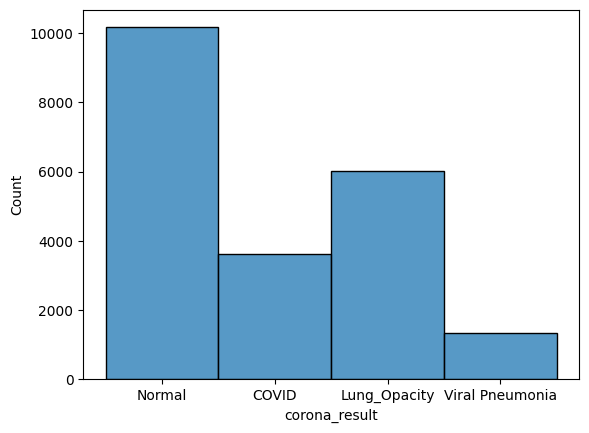

In [ ]:
sns.histplot(data=data, x="corona_result",discrete = True)

In [ ]:
classes=['Normal',"COVID", "Lung_Opacity","Viral Pneumonia"]
# 3 images from each class is being selected to visualize
plot_image={}
for i in classes:
  temp=[]
  datapoints=pd.DataFrame(data[data['corona_result']==i])
  for j in datapoints["image_file"][0:3]:
    temp.append(j)
  plot_image[i]=temp


In [ ]:
def plot_helper(plot_image,class_plot):
  ''' 
  plot_image is the dataset
  class_plot is the class for which images are plotted
  '''
  ax=[0,0,0]
  fig, (ax[0],ax[1],ax[2]) = plt.subplots(1, 3 )
  # plt.title(class_plot)
  ax[1].set_title(class_plot, fontsize = 20)
  for image, ax in zip(plot_image[class_plot],ax):       
        image_read = cv2.imread(image)
        ax.imshow(image_read)
        ax.axis('off')


def plot(plot_image,classes):
  ''' 
  plot_image is the dataset
  classes are all classes 
  '''
  for i in classes:
    plot_helper(plot_image, i)

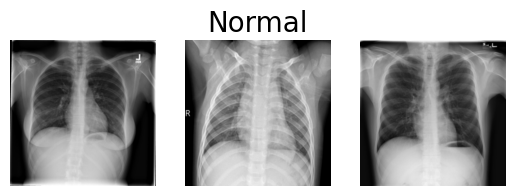

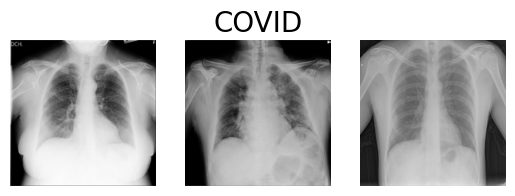

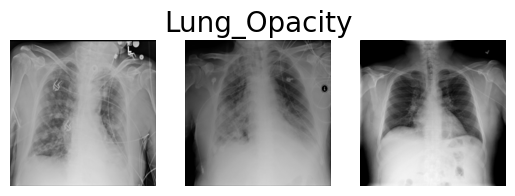

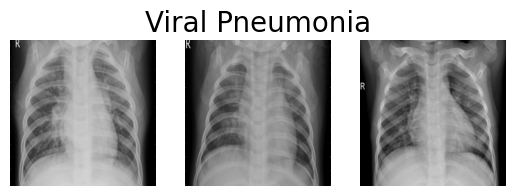

In [ ]:
plot(plot_image, classes)

In [ ]:
data=data.replace('Normal',0)
data=data.replace('COVID',1)
data=data.replace('Lung_Opacity',0)
data=data.replace('Viral Pneumonia',0)

#Original Data

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
df.head()



,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [ ]:
urls = os.listdir('/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images')
path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images/" + urls[0]
path

'/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images/COVID-3312.png'

In [ ]:
def loadImages(path, urls, target):
  images = []
  labels = []
  for i in range(len(urls)):
    img_path = path + "/" + urls[i]
    img = cv2.imread(img_path)
    img = img / 255.0
    #print(img_path)
    # if we want to resize the images
    img = cv2.resize(img, (50,50))
    images.append(img)
    labels.append(target)
  images = np.asarray(images)
  return images, labels
covid_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images"
covidUrl = os.listdir(covid_path)
covidImages, covidTargets = loadImages(covid_path, covidUrl, 1)
len(covidUrl), len(covidImages)

(3616, 3616)

In [ ]:
normal_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Normal/images"
normal_urls = os.listdir(normal_path)
normalImages, normalTargets = loadImages(normal_path, normal_urls, 0)

len(normal_urls)



10164

In [ ]:
lo_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Lung_Opacity/images"
lo_urls = os.listdir(lo_path)
loImages, loTargets = loadImages(lo_path, lo_urls, 0)

In [ ]:
vp_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
vp_urls = os.listdir(vp_path)
vpImages, vpTargets = loadImages(vp_path, vp_urls, 0)

In [ ]:
data = np.r_[covidImages, normalImages,loImages,vpImages]
targets = np.r_[covidTargets, normalTargets, loTargets, vpTargets]

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
len(data)

21123

In [ ]:
resize_data=np.resize(data,(len(data),7500))
scale= StandardScaler()
scaled_data = scale.fit_transform(resize_data) 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(scaled_data, targets, test_size=0.25)

In [ ]:
def classifiers(x_train, y_train, x_test, y_test):
  clf = DecisionTreeClassifier()
  clf.fit(x_train, y_train)
  score = clf.score(x_test, y_test)
  print("Accuracy of Decision Tree Classifier:", score)
  y_pred = clf.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_clf = recall_score( y_test, y_pred)
  print("Recall Score of Decision Tree Classifier:", recall_clf)
  print(classification_report(y_test, y_pred, target_names=target_names))

  rfc = RandomForestClassifier(n_estimators=20, random_state=42)
  rfc.fit(x_train, y_train)
  score_rfc = rfc.score(x_test, y_test)
  print('Accuracy of Random Forest  Classifier:', score_rfc)
  y_pred = rfc.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_rfc = recall_score(y_test, y_pred)
  print("Recall Score of Random Forest Classifier:", recall_rfc)
  print(classification_report(y_test, y_pred, target_names=target_names))

  knn = KNeighborsClassifier(n_neighbors=4)
  knn.fit(x_train, y_train)
  score_knn = knn.score(x_test, y_test)
  print('Accuracy of K Nearest Neighbours Classifier:', score_knn)
  y_pred = knn.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_knn = recall_score(y_test, y_pred)
  print("Recall Score of K Nearest Neighbours Classifier:", recall_knn)
  print(classification_report(y_test, y_pred, target_names=target_names))

  logreg = LogisticRegression(random_state=42)
  logreg.fit(x_train, y_train)
  score_logreg = logreg.score(x_test, y_test)
  print('Accuracy of Logistic Regression:', score_logreg)
  y_pred = logreg.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_logreg = recall_score(y_test, y_pred)
  print("Recall Score of Logistic Regression:", recall_logreg)  
  print(classification_report(y_test, y_pred, target_names=target_names))

  gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
  gbc.fit(x_train, y_train)
  score_gbc = gbc.score(x_test, y_test)
  print('Accuracy of Gradient Boosting:', score_gbc)
  y_pred = gbc.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_gbc = recall_score(y_test, y_pred)
  print("Recall Score of Gradient Boosting:", recall_gbc)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_xgboost=xgboost.XGBClassifier(subsample=0.7)
  classifier_xgboost.fit(x_train, y_train)
  score_xgboost = classifier_xgboost.score(x_test, y_test)
  print('Accuracy of XGBoost:', score_xgboost)
  y_pred = classifier_xgboost.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_xgboost = recall_score(y_test, y_pred)
  print("Recall Score of XGBoost:", recall_classifier_xgboost)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_AdaBoost=AdaBoostClassifier()
  classifier_AdaBoost.fit(x_train, y_train)
  score_AdaBoost = classifier_AdaBoost.score(x_test, y_test)
  print('Accuracy of AdaBoost Classifier:', score_AdaBoost)
  y_pred = classifier_AdaBoost.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_AdaBoost = recall_score(y_test, y_pred)
  print("Recall Score of AdaBoost Classifier:", recall_classifier_AdaBoost)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_lightgbm=lightgbm.LGBMClassifier(num_leaves=6)
  classifier_lightgbm.fit(x_train, y_train)
  score_lightgbm = classifier_lightgbm.score(x_test, y_test)
  print('Accuracy of LightGBM Classifier:', score_lightgbm)
  y_pred = classifier_lightgbm.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_lightgbm = recall_score(y_test, y_pred)
  print("Recall Score of LightGBM Classifier:", recall_classifier_lightgbm)
  print(classification_report(y_test, y_pred, target_names=target_names))
  

  plt.figure(figsize=(16,10))
  classifiers = ['Decision Tree Classifier', 'Random Forest Classifier', 'KNN', 'Logistic Regression', 'Gradient Boosting', 'XGBoost', 'AdaBoost','LightGBM']
  accuracies = [score, score_rfc, score_knn, score_logreg, score_gbc, score_xgboost, score_AdaBoost, score_lightgbm]
  recall = [recall_clf, recall_rfc, recall_knn, recall_logreg, recall_gbc, recall_classifier_xgboost, recall_classifier_AdaBoost, recall_classifier_lightgbm]
  plt.plot(classifiers, accuracies , label = 'Accuracy')
  plt.scatter(classifiers, accuracies )

  plt.plot(classifiers, recall , label = 'Recall')
  plt.scatter(classifiers, recall )

  plt.xlabel('classifiers')
  plt.ylabel('scores')
  plt.legend()
  plt.show()

Accuracy of Decision Tree Classifier: 0.8846809316417346
Recall Score of Decision Tree Classifier: 0.657010428736964
              precision    recall  f1-score   support

     Class 0       0.93      0.93      0.93      4418
     Class 1       0.64      0.66      0.65       863

    accuracy                           0.88      5281
   macro avg       0.79      0.79      0.79      5281
weighted avg       0.89      0.88      0.89      5281

Accuracy of Random Forest  Classifier: 0.9244461276273434
Recall Score of Random Forest Classifier: 0.5979142526071842
              precision    recall  f1-score   support

     Class 0       0.93      0.99      0.96      4418
     Class 1       0.91      0.60      0.72       863

    accuracy                           0.92      5281
   macro avg       0.92      0.79      0.84      5281
weighted avg       0.92      0.92      0.92      5281

Accuracy of K Nearest Neighbours Classifier: 0.8962317742851733
Recall Score of K Nearest Neighbours Classifie

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of Logistic Regression: 0.8534368490816133
Recall Score of Logistic Regression: 0.473928157589803
              precision    recall  f1-score   support

     Class 0       0.90      0.93      0.91      4418
     Class 1       0.56      0.47      0.51       863

    accuracy                           0.85      5281
   macro avg       0.73      0.70      0.71      5281
weighted avg       0.84      0.85      0.85      5281

Accuracy of Gradient Boosting: 0.9056996780912706
Recall Score of Gradient Boosting: 0.5017381228273464
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95      4418
     Class 1       0.86      0.50      0.63       863

    accuracy                           0.91      5281
   macro avg       0.89      0.74      0.79      5281
weighted avg       0.90      0.91      0.90      5281

Accuracy of XGBoost: 0.9536072713501231
Recall Score of XGBoost: 0.7809965237543454
              precision    recall  f1-score   suppo

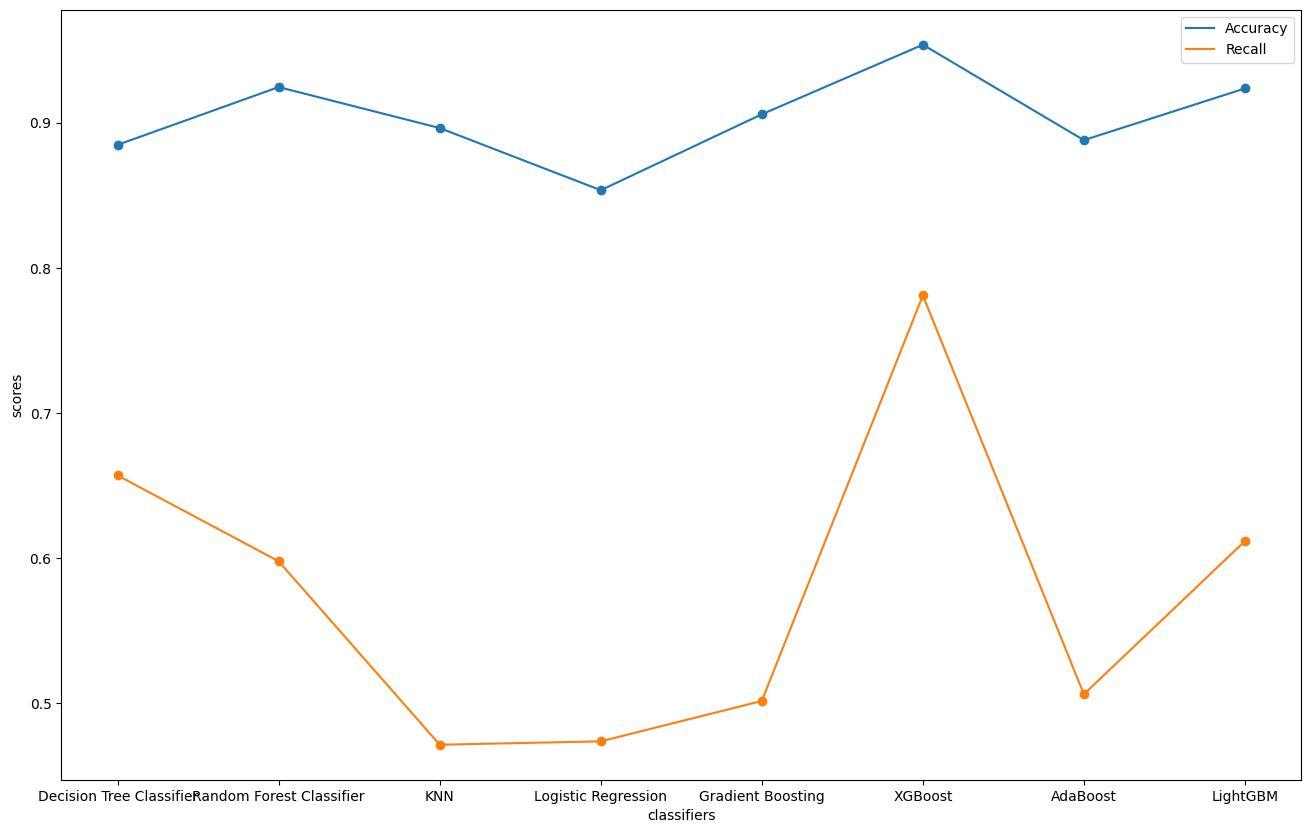

In [ ]:
classifiers(x_train, y_train, x_test, y_test)

#LDA on original data

In [ ]:
urls = os.listdir('/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images')
path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images/" + urls[0]
path

'/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images/COVID-3312.png'

In [ ]:
def loadImages(path, urls, target):
  images = []
  labels = []
  for i in range(len(urls)):
    img_path = path + "/" + urls[i]
    img = cv2.imread(img_path)
    

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gray = img_gray / 255.0
    # if we want to resize the images
    img = cv2.resize(img_gray, (50,50))
    images.append(img)
    labels.append(target)
  images = np.asarray(images)
  return images, labels
covid_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images"
covidUrl = os.listdir(covid_path)
covidImages, covidTargets = loadImages(covid_path, covidUrl, 1)
len(covidUrl), len(covidImages)

(3616, 3616)

In [ ]:
normal_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Normal/images"
normal_urls = os.listdir(normal_path)
normalImages, normalTargets = loadImages(normal_path, normal_urls, 0)
len(normal_urls)

10164

In [ ]:
lo_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Lung_Opacity/images"
lo_urls = os.listdir(lo_path)
loImages, loTargets = loadImages(lo_path, lo_urls, 0)

In [ ]:
vp_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
vp_urls = os.listdir(vp_path)
vpImages, vpTargets = loadImages(vp_path, vp_urls, 0)



In [ ]:
data = np.r_[covidImages, normalImages,loImages,vpImages]
targets = np.r_[covidTargets, normalTargets, loTargets, vpTargets]

In [ ]:
data

array([[[0.13643765, 0.        , 0.04323529, ..., 0.00192157,
         0.00192157, 0.3292902 ],
        [0.39854196, 0.40532314, 0.        , ..., 0.        ,
         0.        , 0.00101843],
        [0.10376471, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.01192157, 0.        , 0.        , ..., 0.18882353,
         0.        , 0.00392157],
        [0.01192157, 0.        , 0.        , ..., 0.28564118,
         0.02011412, 0.00392157],
        [0.00890157, 0.        , 0.        , ..., 0.3943098 ,
         0.08976118, 0.00192157]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.40520745],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.00207843],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.62687255,
         0.64014706, 0.31356863],
        [0. 

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
len(data)
# len(data.T)


21123

In [ ]:
resize_data=np.resize(data,(len(data),2500))
from sklearn.preprocessing import StandardScaler
scale= StandardScaler()
scaled_data = scale.fit_transform(resize_data) 


In [ ]:
scaled_data.shape

(21123, 2500)

In [ ]:
np.unique(targets)

array([0, 1])

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components = 1)
lda.fit(scaled_data, targets)
X_lda = lda.transform(scaled_data)
X_lda

array([[ 1.97948312],
       [ 0.5902924 ],
       [ 1.25424472],
       ...,
       [ 1.58173199],
       [-0.90685357],
       [-0.53402513]])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_lda, targets, test_size=0.30)
# x_val, x_test, y_val, y_test = train_test_split(x_test, x_test, test_size=0.33)

Desicion Tree 

In [ ]:
print(x_test)

[[-0.78678881]
 [-0.07594848]
 [-0.96065808]
 ...
 [-0.40700131]
 [-0.06210897]
 [-1.01562905]]


Accuracy of Decision Tree Classifier: 0.8548208931671137
Recall Score of Decision Tree Classifier: 0.577386468952734
              precision    recall  f1-score   support

     Class 0       0.91      0.91      0.91      5258
     Class 1       0.57      0.58      0.58      1079

    accuracy                           0.85      6337
   macro avg       0.74      0.74      0.74      6337
weighted avg       0.86      0.85      0.86      6337

Accuracy of Random Forest  Classifier: 0.8606596181158277
Recall Score of Random Forest Classifier: 0.5727525486561631
              precision    recall  f1-score   support

     Class 0       0.91      0.92      0.92      5258
     Class 1       0.59      0.57      0.58      1079

    accuracy                           0.86      6337
   macro avg       0.75      0.75      0.75      6337
weighted avg       0.86      0.86      0.86      6337

Accuracy of K Nearest Neighbours Classifier: 0.8865393719425596
Recall Score of K Nearest Neighbours Classifie

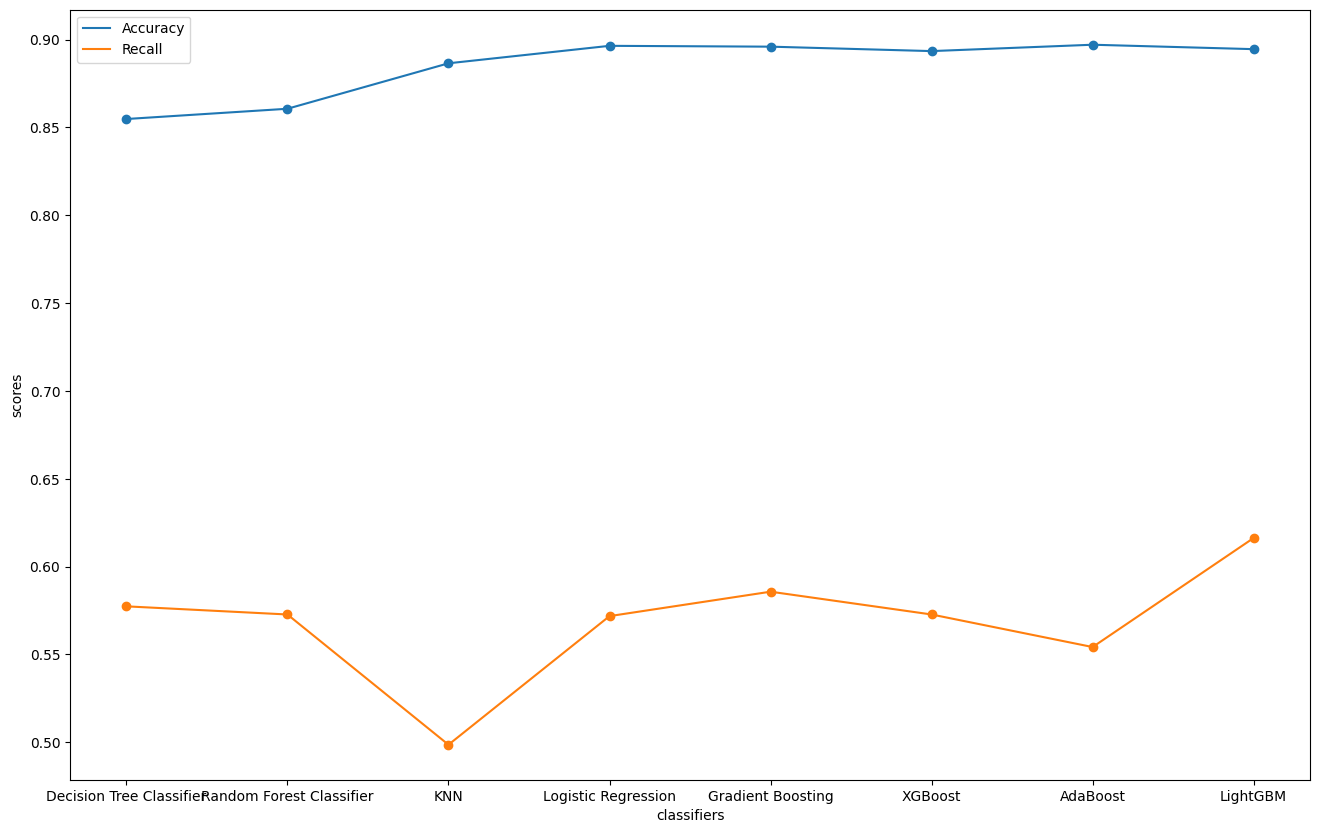

In [ ]:
classifiers(x_train, y_train, x_test, y_test)

#LDA on masked data

In [ ]:
urls = os.listdir('/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/masks')
path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/masks/" + urls[0]
path

'/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/masks/COVID-3216.png'

In [ ]:
def loadImages(path, urls, target):
  images = []
  labels = []
  for i in range(len(urls)):
    img_path = path + "/" + urls[i]
    img = cv2.imread(img_path)
    

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gray = img_gray / 255.0
    # if we want to resize the images
    img = cv2.resize(img_gray, (50,50))
    images.append(img)
    labels.append(target)
  images = np.asarray(images)
  return images, labels
covid_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/masks"
covidUrl = os.listdir(covid_path)
covidImages, covidTargets = loadImages(covid_path, covidUrl, 1)
len(covidUrl), len(covidImages)

(3616, 3616)

In [ ]:
normal_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Normal/masks"
normal_urls = os.listdir(normal_path)
normalImages, normalTargets = loadImages(normal_path, normal_urls, 0)
len(normal_urls)

10164

In [ ]:
lo_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Lung_Opacity/masks"
lo_urls = os.listdir(lo_path)
loImages, loTargets = loadImages(lo_path, lo_urls, 0)

In [ ]:
vp_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Viral Pneumonia/masks"
vp_urls = os.listdir(vp_path)
vpImages, vpTargets = loadImages(vp_path, vp_urls, 0)



In [ ]:
data = np.r_[covidImages, normalImages,loImages,vpImages]
targets = np.r_[covidTargets, normalTargets, loTargets, vpTargets]

In [ ]:
data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
len(data)
# len(data.T)


21124

In [ ]:
resize_data=np.resize(data,(len(data),2500))
scale= StandardScaler()
scaled_data = scale.fit_transform(resize_data) 


In [ ]:
scaled_data.shape

(21124, 2500)

In [ ]:
np.unique(targets)

array([0, 1])

In [ ]:
lda = LinearDiscriminantAnalysis(n_components = 1)
lda.fit(scaled_data, targets)
X_lda = lda.transform(scaled_data)
X_lda

array([[-0.33960661],
       [ 1.56467223],
       [ 0.69026641],
       ...,
       [-1.01546053],
       [-1.12720953],
       [-1.40603307]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_lda, targets, test_size=0.30)

Accuracy of Decision Tree Classifier: 0.7940990848848217
Recall Score of Decision Tree Classifier: 0.4041034790365745
              precision    recall  f1-score   support

     Class 0       0.87      0.88      0.88      5217
     Class 1       0.42      0.40      0.41      1121

    accuracy                           0.79      6338
   macro avg       0.64      0.64      0.64      6338
weighted avg       0.79      0.79      0.79      6338

Accuracy of Random Forest  Classifier: 0.7991479962133166
Recall Score of Random Forest Classifier: 0.3960749330954505
              precision    recall  f1-score   support

     Class 0       0.87      0.89      0.88      5217
     Class 1       0.43      0.40      0.41      1121

    accuracy                           0.80      6338
   macro avg       0.65      0.64      0.64      6338
weighted avg       0.79      0.80      0.80      6338

Accuracy of K Nearest Neighbours Classifier: 0.8475859892710634
Recall Score of K Nearest Neighbours Classifi

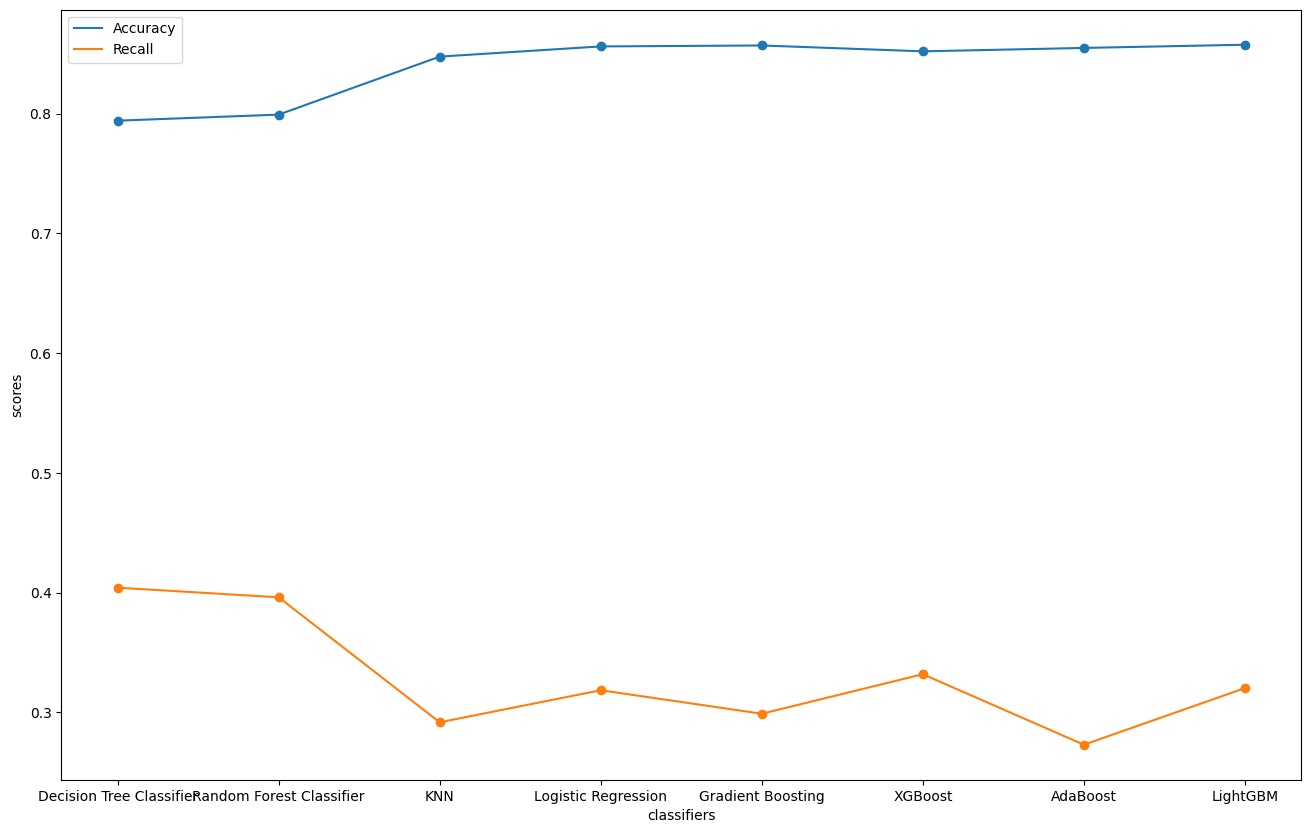

In [ ]:
classifiers(x_train, y_train, x_test, y_test)

# PCA with rgb channels

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Major Project/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
df.head()
urls = os.listdir('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/images')
path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/images/" + urls[0]
path

'/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/images/COVID-1024.png'

In [ ]:
def loadImages(path, urls, target):
  images = []
  labels = []
  for i in range(len(urls)):
    img_path = path + "/" + urls[i]
    img = cv2.imread(img_path)
    img = img / 255.0
    #print(img_path)
    # if we want to resize the images
    img = cv2.resize(img, (50,50))
    images.append(img)
    labels.append(target)
  images = np.asarray(images)
  return images, labels


In [ ]:
covid_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/images"
covidUrl = os.listdir(covid_path)
covidImages, covidTargets = loadImages(covid_path, covidUrl, 1)
len(covidUrl), len(covidImages)

normal_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images"
normal_urls = os.listdir(normal_path)
normalImages, normalTargets = loadImages(normal_path, normal_urls, 0)
len(normal_urls)

lo_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/images"
lo_urls = os.listdir(lo_path)
loImages, loTargets = loadImages(lo_path, lo_urls, 0)

vp_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
vp_urls = os.listdir(vp_path)
vpImages, vpTargets = loadImages(vp_path, vp_urls, 0)



In [ ]:
data = np.r_[covidImages, normalImages,loImages,vpImages]
targets = np.r_[covidTargets, normalTargets, loTargets, vpTargets]

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
resize_data=np.resize(data,(len(data),7500))
scale= StandardScaler()
scaled_data = scale.fit_transform(resize_data) 

In [ ]:
scaled_data.shape

(18116, 7500)

In [ ]:
pca = PCA(n_components=2)
pca.fit(scaled_data)
print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

[0.25509175 0.13949293]


PCA with 1 features
PCA with 2 features
PCA with 3 features
PCA with 4 features
PCA with 5 features
PCA with 6 features
[0.2550917534540098, 0.3945846793813486, 0.469326208340385, 0.533321236446459, 0.5925058797833016, 0.629176342724159]
['1', '2', '3', '4', '5', '6']


<BarContainer object of 6 artists>

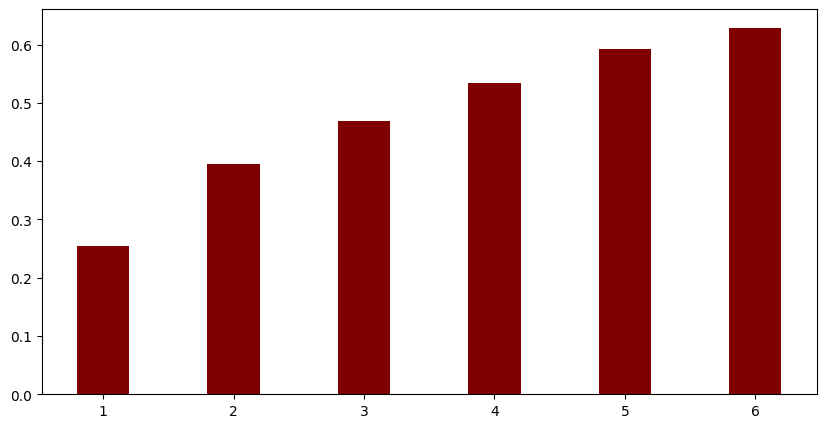

In [ ]:
var=[]
comp=[]
for i in range(1,7):
  print("PCA with", i, "features")
  pca = PCA(n_components = i).fit(scaled_data)
  var.append(np.sum(pca.explained_variance_ratio_))
  comp.append(str(i))

print(var)
print(comp)
  
fig = plt.figure(figsize = (10, 5))
plt.bar(comp, var, color ='maroon', width = 0.4)

In [ ]:
pca = PCA(n_components = 6).fit(scaled_data)
print("Variance captured is:",np.sum(pca.explained_variance_ratio_))
x_scaled_data_pca=pca.fit_transform(scaled_data)

Variance captured is: 0.6291763427617159


In [ ]:
x_scaled_data_pca=np.resize(x_scaled_data_pca,(len(x_scaled_data_pca),6))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled_data_pca, targets, test_size=0.30)

In [ ]:
def classifiers(x_train, y_train, x_test, y_test):
  clf = DecisionTreeClassifier()
  clf.fit(x_train, y_train)
  score = clf.score(x_test, y_test)
  print("Accuracy of Decision Tree Classifier:", score)
  y_pred = clf.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_clf = recall_score( y_test, y_pred)
  print("Recall Score of Decision Tree Classifier:", recall_clf)
  print(classification_report(y_test, y_pred, target_names=target_names))

  rfc = RandomForestClassifier(n_estimators=20, random_state=42)
  rfc.fit(x_train, y_train)
  score_rfc = rfc.score(x_test, y_test)
  print('Accuracy of Random Forest  Classifier:', score_rfc)
  y_pred = rfc.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_rfc = recall_score(y_test, y_pred)
  print("Recall Score of Random Forest Classifier:", recall_rfc)
  print(classification_report(y_test, y_pred, target_names=target_names))

  knn = KNeighborsClassifier(n_neighbors=4)
  knn.fit(x_train, y_train)
  score_knn = knn.score(x_test, y_test)
  print('Accuracy of K Nearest Neighbours Classifier:', score_knn)
  y_pred = knn.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_knn = recall_score(y_test, y_pred)
  print("Recall Score of K Nearest Neighbours Classifier:", recall_knn)
  print(classification_report(y_test, y_pred, target_names=target_names))

  logreg = LogisticRegression(random_state=42)
  logreg.fit(x_train, y_train)
  score_logreg = logreg.score(x_test, y_test)
  print('Accuracy of Logistic Regression:', score_logreg)
  y_pred = logreg.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_logreg = recall_score(y_test, y_pred)
  print("Recall Score of Logistic Regression:", recall_logreg)  
  print(classification_report(y_test, y_pred, target_names=target_names))

  gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
  gbc.fit(x_train, y_train)
  score_gbc = gbc.score(x_test, y_test)
  print('Accuracy of Gradient Boosting:', score_gbc)
  y_pred = gbc.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_gbc = recall_score(y_test, y_pred)
  print("Recall Score of Gradient Boosting:", recall_gbc)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_xgboost=xgboost.XGBClassifier(subsample=0.7)
  classifier_xgboost.fit(x_train, y_train)
  score_xgboost = classifier_xgboost.score(x_test, y_test)
  print('Accuracy of XGBoost:', score_xgboost)
  y_pred = classifier_xgboost.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_xgboost = recall_score(y_test, y_pred)
  print("Recall Score of XGBoost:", recall_classifier_xgboost)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_AdaBoost=AdaBoostClassifier()
  classifier_AdaBoost.fit(x_train, y_train)
  score_AdaBoost = classifier_AdaBoost.score(x_test, y_test)
  print('Accuracy of AdaBoost Classifier:', score_AdaBoost)
  y_pred = classifier_AdaBoost.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_AdaBoost = recall_score(y_test, y_pred)
  print("Recall Score of AdaBoost Classifier:", recall_classifier_AdaBoost)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_lightgbm=lightgbm.LGBMClassifier(num_leaves=6)
  classifier_lightgbm.fit(x_train, y_train)
  score_lightgbm = classifier_lightgbm.score(x_test, y_test)
  print('Accuracy of LightGBM Classifier:', score_lightgbm)
  y_pred = classifier_lightgbm.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_lightgbm = recall_score(y_test, y_pred)
  print("Recall Score of LightGBM Classifier:", recall_classifier_lightgbm)
  print(classification_report(y_test, y_pred, target_names=target_names))
  

  plt.figure(figsize=(16,10))
  classifiers = ['Decision Tree Classifier', 'Random Forest Classifier', 'KNN', 'Logistic Regression', 'Gradient Boosting', 'XGBoost', 'AdaBoost','LightGBM']
  accuracies = [score, score_rfc, score_knn, score_logreg, score_gbc, score_xgboost, score_AdaBoost, score_lightgbm]
  recall = [recall_clf, recall_rfc, recall_knn, recall_logreg, recall_gbc, recall_classifier_xgboost, recall_classifier_AdaBoost, recall_classifier_lightgbm]
  plt.plot(classifiers, accuracies , label = 'Accuracy')
  plt.scatter(classifiers, accuracies )

  plt.plot(classifiers, recall , label = 'Recall')
  plt.scatter(classifiers, recall )

  plt.xlabel('classifiers')
  plt.ylabel('scores')
  plt.legend()
  plt.show()

Accuracy of Decision Tree Classifier: 0.9389144434222632
Recall Score of Decision Tree Classifier: 0.1781609195402299
              precision    recall  f1-score   support

     Class 0       0.97      0.96      0.97      5261
     Class 1       0.14      0.18      0.16       174

    accuracy                           0.94      5435
   macro avg       0.56      0.57      0.56      5435
weighted avg       0.95      0.94      0.94      5435

Accuracy of Random Forest  Classifier: 0.9696412143514259
Recall Score of Random Forest Classifier: 0.08045977011494253
              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98      5261
     Class 1       0.74      0.08      0.15       174

    accuracy                           0.97      5435
   macro avg       0.85      0.54      0.56      5435
weighted avg       0.96      0.97      0.96      5435

Accuracy of K Nearest Neighbours Classifier: 0.9678012879484821
Recall Score of K Nearest Neighbours Classif

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of Gradient Boosting: 0.9678012879484821
Recall Score of Gradient Boosting: 0.04597701149425287
              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98      5261
     Class 1       0.47      0.05      0.08       174

    accuracy                           0.97      5435
   macro avg       0.72      0.52      0.53      5435
weighted avg       0.95      0.97      0.95      5435

Accuracy of Gradient Boosting: 0.9672493100275988
Recall Score of XGBoost: 0.10344827586206896
              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98      5261
     Class 1       0.45      0.10      0.17       174

    accuracy                           0.97      5435
   macro avg       0.71      0.55      0.58      5435
weighted avg       0.95      0.97      0.96      5435

Accuracy of AdaBoost Classifier: 0.9676172953081876
Recall Score of AdaBoost Classifier: 0.034482758620689655
              precision    recall  f

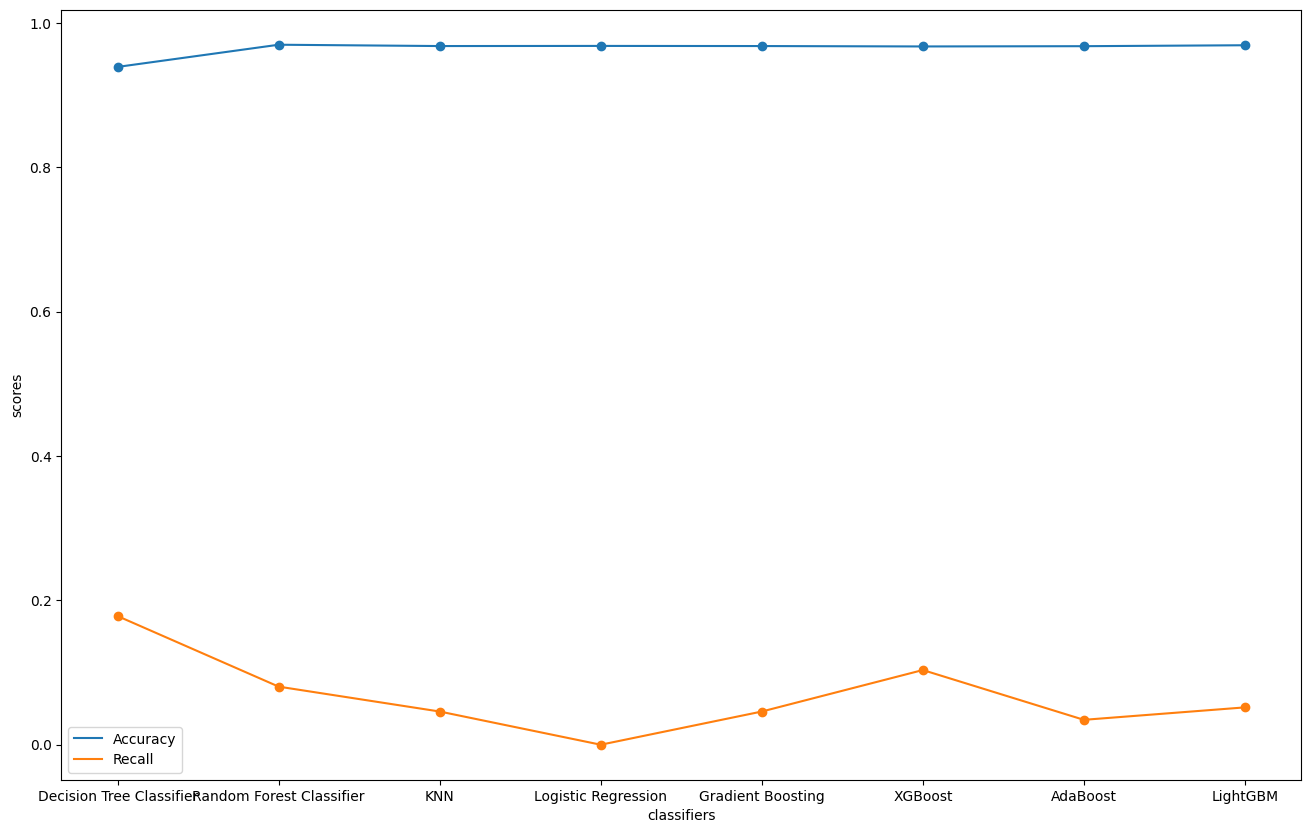

In [ ]:
classifiers(x_train, y_train, x_test, y_test)

# CNN on rgb channels

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.30)

In [ ]:
model = Sequential([
    Conv2D(32, 3, input_shape=(50,50,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 16)          2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 16)         0

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
model.fit(x_train, y_train,batch_size=32,epochs=5,validation_data=(x_test, y_test))

Epoch 1/5
397/397 [==============================] - 19s 12ms/step - loss: 0.1660 - accuracy: 0.9632 - val_loss: 0.1456 - val_accuracy: 0.9656
Epoch 2/5
397/397 [==============================] - 3s 8ms/step - loss: 0.1435 - accuracy: 0.9651 - val_loss: 0.1329 - val_accuracy: 0.9656
Epoch 3/5
397/397 [==============================] - 3s 7ms/step - loss: 0.1325 - accuracy: 0.9651 - val_loss: 0.1289 - val_accuracy: 0.9656
Epoch 4/5
397/397 [==============================] - 3s 7ms/step - loss: 0.1242 - accuracy: 0.9651 - val_loss: 0.1261 - val_accuracy: 0.9656
Epoch 5/5
397/397 [==============================] - 4s 9ms/step - loss: 0.1174 - accuracy: 0.9655 - val_loss: 0.1198 - val_accuracy: 0.9656


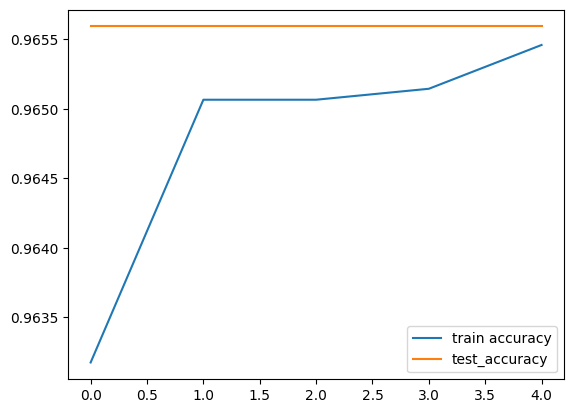

In [ ]:
plt.plot(model.history.history['accuracy'], label = 'train accuracy')
plt.plot(model.history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

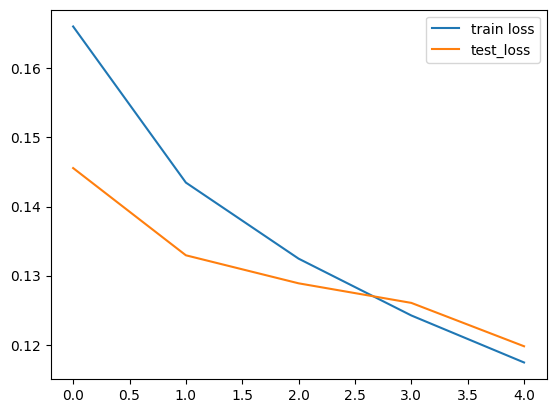

In [ ]:
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

In [ ]:
model.compile(optimizer='SGD', loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
model.fit(x_train, y_train,batch_size=32,epochs=5,validation_data=(x_test, y_test))

Epoch 1/5
397/397 [==============================] - 6s 9ms/step - loss: 0.1047 - accuracy: 0.9676 - val_loss: 0.1101 - val_accuracy: 0.9667
Epoch 2/5
397/397 [==============================] - 3s 8ms/step - loss: 0.1018 - accuracy: 0.9685 - val_loss: 0.1112 - val_accuracy: 0.9667
Epoch 3/5
397/397 [==============================] - 4s 10ms/step - loss: 0.1003 - accuracy: 0.9694 - val_loss: 0.1078 - val_accuracy: 0.9672
Epoch 4/5
397/397 [==============================] - 4s 10ms/step - loss: 0.0994 - accuracy: 0.9685 - val_loss: 0.1085 - val_accuracy: 0.9684
Epoch 5/5
397/397 [==============================] - 3s 7ms/step - loss: 0.0980 - accuracy: 0.9689 - val_loss: 0.1068 - val_accuracy: 0.9671


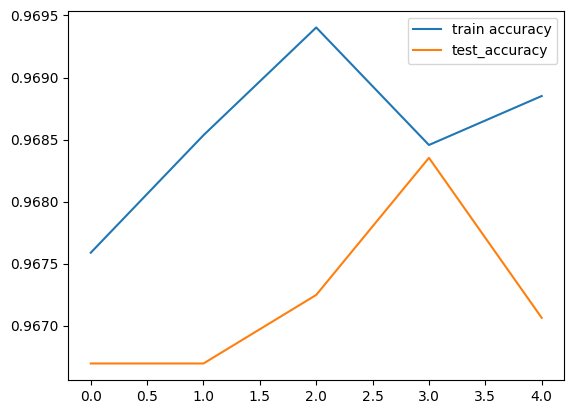

In [ ]:
plt.plot(model.history.history['accuracy'], label = 'train accuracy')
plt.plot(model.history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

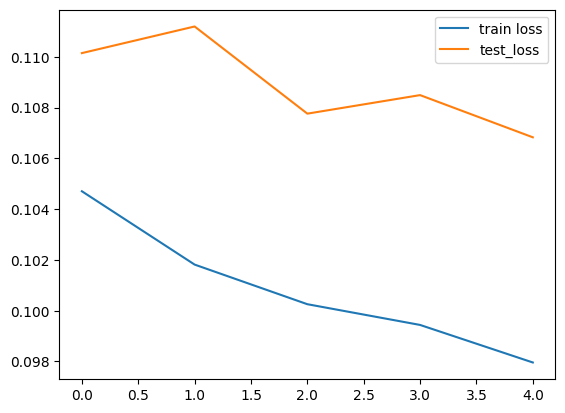

In [ ]:
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

# Gray scale

In [ ]:
urls = os.listdir('/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images')
path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images/" + urls[0]
path

'/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images/COVID-3312.png'

In [ ]:
def loadImages(path, urls, target):
  images = []
  labels = []
  for i in range(len(urls)):
    img_path = path + "/" + urls[i]
    img = cv2.imread(img_path)
    

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gray = img_gray / 255.0
    # if we want to resize the images
    img = cv2.resize(img_gray, (50,50))
    images.append(img)
    labels.append(target)
  images = np.asarray(images)
  return images, labels
covid_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images"
covidUrl = os.listdir(covid_path)
covidImages, covidTargets = loadImages(covid_path, covidUrl, 1)
len(covidUrl), len(covidImages)

(3616, 3616)

In [ ]:
normal_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Normal/images"
normal_urls = os.listdir(normal_path)
normalImages, normalTargets = loadImages(normal_path, normal_urls, 0)
len(normal_urls)

10164

In [ ]:
lo_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Lung_Opacity/images"
lo_urls = os.listdir(lo_path)
loImages, loTargets = loadImages(lo_path, lo_urls, 0)

In [ ]:
vp_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
vp_urls = os.listdir(vp_path)
vpImages, vpTargets = loadImages(vp_path, vp_urls, 0)



In [ ]:
data = np.r_[covidImages, normalImages,loImages,vpImages]
targets = np.r_[covidTargets, normalTargets, loTargets, vpTargets]

In [ ]:
data

array([[[0.13643765, 0.        , 0.04323529, ..., 0.00192157,
         0.00192157, 0.3292902 ],
        [0.39854196, 0.40532314, 0.        , ..., 0.        ,
         0.        , 0.00101843],
        [0.10376471, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.01192157, 0.        , 0.        , ..., 0.18882353,
         0.        , 0.00392157],
        [0.01192157, 0.        , 0.        , ..., 0.28564118,
         0.02011412, 0.00392157],
        [0.00890157, 0.        , 0.        , ..., 0.3943098 ,
         0.08976118, 0.00192157]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.40520745],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.00207843],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.62687255,
         0.64014706, 0.31356863],
        [0. 

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
len(data)
# len(data.T)


21123

In [ ]:
resize_data=np.resize(data,(len(data),2500))
scale= StandardScaler()
scaled_data = scale.fit_transform(resize_data) 


In [ ]:
scaled_data.shape

(21123, 2500)

In [ ]:
pca = PCA(n_components=2)
pca.fit(scaled_data)

print(pca.explained_variance_ratio_)

# print(pca.singular_values_)

[0.26366043 0.12787757]


PCA with 1 features
PCA with 2 features
PCA with 3 features
PCA with 4 features
PCA with 5 features
PCA with 6 features
[0.26366043212898094, 0.3915380002382323, 0.46520098653812514, 0.5304655178033963, 0.5913625833800337, 0.6291715463583417]
['1', '2', '3', '4', '5', '6']


<BarContainer object of 6 artists>

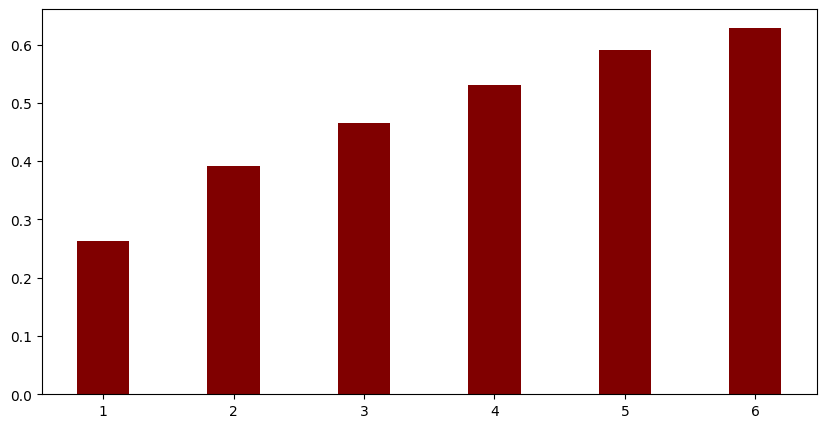

In [ ]:
var=[]
comp=[]
for i in range(1,7):
  print("PCA with", i, "features")
  pca = PCA(n_components = i).fit(scaled_data)
  var.append(np.sum(pca.explained_variance_ratio_))
  comp.append(str(i))

print(var)
print(comp)
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(comp, var, color ='maroon', width = 0.4)

In [ ]:
pca = PCA(n_components = 6).fit(scaled_data)
print("Variance captured is:",np.sum(pca.explained_variance_ratio_))
x_scaled_data_pca=pca.fit_transform(scaled_data)

Variance captured is: 0.6291715463586295


In [ ]:
x_scaled_data_pca=np.resize(x_scaled_data_pca,(len(x_scaled_data_pca),6))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled_data_pca, targets, test_size=0.30)

Accuracy of Decision Tree Classifier: 0.8128451948871706
Recall Score of Decision Tree Classifier: 0.48420074349442377
              precision    recall  f1-score   support

     Class 0       0.89      0.88      0.89      5261
     Class 1       0.45      0.48      0.47      1076

    accuracy                           0.81      6337
   macro avg       0.67      0.68      0.68      6337
weighted avg       0.82      0.81      0.82      6337

Accuracy of Random Forest  Classifier: 0.8745463152911472
Recall Score of Random Forest Classifier: 0.3903345724907063
              precision    recall  f1-score   support

     Class 0       0.89      0.97      0.93      5261
     Class 1       0.75      0.39      0.51      1076

    accuracy                           0.87      6337
   macro avg       0.82      0.68      0.72      6337
weighted avg       0.86      0.87      0.86      6337

Accuracy of K Nearest Neighbours Classifier: 0.8586081742149282
Recall Score of K Nearest Neighbours Classif

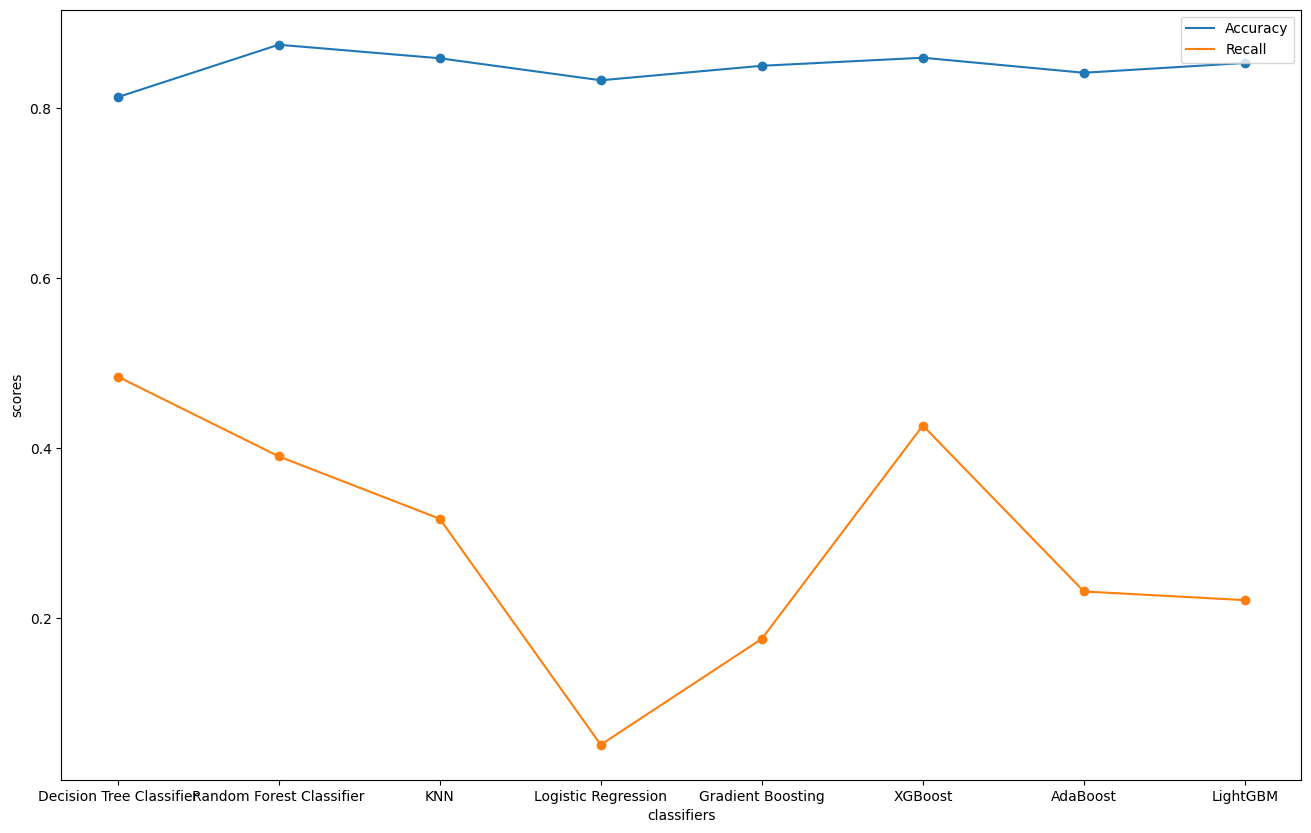

In [ ]:
classifiers(x_train, y_train, x_test, y_test)

# On masked  images

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
df.head()
urls = os.listdir('/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/masks')
path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/masks/" + urls[0]
path

'/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/masks/COVID-3216.png'

In [ ]:
def loadImages(path, urls, target):
  images = []
  labels = []
  for i in range(len(urls)):
    img_path = path + "/" + urls[i]
    img = cv2.imread(img_path)
    img = img / 255.0
    #print(img_path)
    # if we want to resize the images
    img = cv2.resize(img, (50,50))
    images.append(img)
    labels.append(target)
  images = np.asarray(images)
  return images, labels


In [ ]:
covid_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/masks"
covidUrl = os.listdir(covid_path)
covidImages, covidTargets = loadImages(covid_path, covidUrl, 1)
len(covidUrl), len(covidImages)

normal_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Normal/masks"
normal_urls = os.listdir(normal_path)
normalImages, normalTargets = loadImages(normal_path, normal_urls, 0)
len(normal_urls)

lo_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Lung_Opacity/masks"
lo_urls = os.listdir(lo_path)
loImages, loTargets = loadImages(lo_path, lo_urls, 0)

vp_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Viral Pneumonia/masks"
vp_urls = os.listdir(vp_path)
vpImages, vpTargets = loadImages(vp_path, vp_urls, 0)



In [ ]:
data = np.r_[covidImages, normalImages,loImages,vpImages]
targets = np.r_[covidTargets, normalTargets, loTargets, vpTargets]

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
resize_data=np.resize(data,(len(data),7500))
scale= StandardScaler()
scaled_data = scale.fit_transform(resize_data) 

In [ ]:
scaled_data.shape

(21124, 7500)

In [ ]:
pca = PCA(n_components=2)
pca.fit(scaled_data)
print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

[0.07793518 0.07219649]


PCA with 1 features
PCA with 2 features
PCA with 3 features
PCA with 4 features
PCA with 5 features
PCA with 6 features
PCA with 7 features
PCA with 8 features
PCA with 9 features
PCA with 10 features
PCA with 11 features
PCA with 12 features
PCA with 13 features
PCA with 14 features
PCA with 15 features
PCA with 16 features
PCA with 17 features
PCA with 18 features
PCA with 19 features
[0.0779351794852586, 0.1501316728242739, 0.21569699988459473, 0.2698730864930262, 0.30146600320555583, 0.3294189857219547, 0.3544331805682216, 0.3762465692424203, 0.39621413067722805, 0.41421235436505727, 0.4306766522090095, 0.44634644189096934, 0.46101095743681464, 0.473898846918405, 0.4854848873510178, 0.4955526895560642, 0.5053329150472141, 0.5147974693153886, 0.5232660575283552]
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


<BarContainer object of 19 artists>

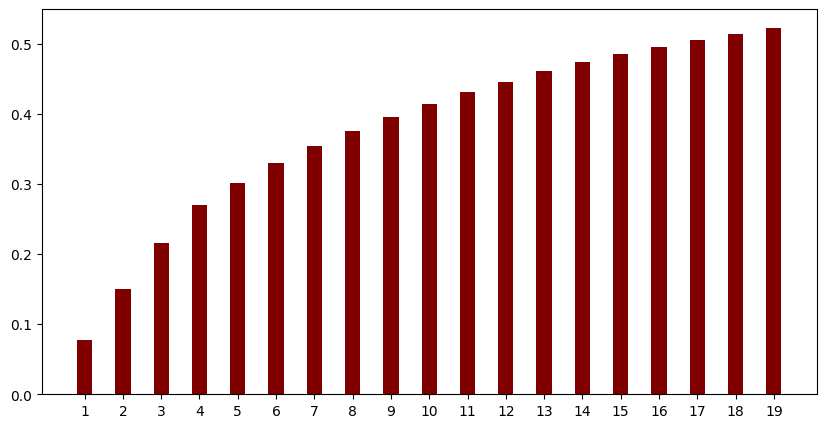

In [ ]:
var=[]
comp=[]
for i in range(1,20):
  print("PCA with", i, "features")
  pca = PCA(n_components = i).fit(scaled_data)
  var.append(np.sum(pca.explained_variance_ratio_))
  comp.append(str(i))

print(var)
print(comp)
  
fig = plt.figure(figsize = (10, 5))
plt.bar(comp, var, color ='maroon', width = 0.4)

In [ ]:
pca = PCA(n_components = 10).fit(scaled_data)
print("Variance captured is:",np.sum(pca.explained_variance_ratio_))
x_scaled_data_pca=pca.fit_transform(scaled_data)

Variance captured is: 0.4142120841007335


In [ ]:
x_scaled_data_pca=np.resize(x_scaled_data_pca,(len(x_scaled_data_pca),10))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled_data_pca, targets, test_size=0.30)

In [ ]:
def classifiers(x_train, y_train, x_test, y_test):
  clf = DecisionTreeClassifier()
  clf.fit(x_train, y_train)
  score = clf.score(x_test, y_test)
  print("Accuracy of Decision Tree Classifier:", score)
  y_pred = clf.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_clf = recall_score( y_test, y_pred)
  print("Recall Score of Decision Tree Classifier:", recall_clf)
  print(classification_report(y_test, y_pred, target_names=target_names))

  rfc = RandomForestClassifier(n_estimators=20, random_state=42)
  rfc.fit(x_train, y_train)
  score_rfc = rfc.score(x_test, y_test)
  print('Accuracy of Random Forest  Classifier:', score_rfc)
  y_pred = rfc.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_rfc = recall_score(y_test, y_pred)
  print("Recall Score of Random Forest Classifier:", recall_rfc)
  print(classification_report(y_test, y_pred, target_names=target_names))

  knn = KNeighborsClassifier(n_neighbors=4)
  knn.fit(x_train, y_train)
  score_knn = knn.score(x_test, y_test)
  print('Accuracy of K Nearest Neighbours Classifier:', score_knn)
  y_pred = knn.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_knn = recall_score(y_test, y_pred)
  print("Recall Score of K Nearest Neighbours Classifier:", recall_knn)
  print(classification_report(y_test, y_pred, target_names=target_names))

  logreg = LogisticRegression(random_state=42)
  logreg.fit(x_train, y_train)
  score_logreg = logreg.score(x_test, y_test)
  print('Accuracy of Logistic Regression:', score_logreg)
  y_pred = logreg.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_logreg = recall_score(y_test, y_pred)
  print("Recall Score of Logistic Regression:", recall_logreg)  
  print(classification_report(y_test, y_pred, target_names=target_names))

  gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
  gbc.fit(x_train, y_train)
  score_gbc = gbc.score(x_test, y_test)
  print('Accuracy of Gradient Boosting:', score_gbc)
  y_pred = gbc.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_gbc = recall_score(y_test, y_pred)
  print("Recall Score of Gradient Boosting:", recall_gbc)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_xgboost=xgboost.XGBClassifier(subsample=0.7)
  classifier_xgboost.fit(x_train, y_train)
  score_xgboost = classifier_xgboost.score(x_test, y_test)
  print('Accuracy of XGBoost:', score_xgboost)
  y_pred = classifier_xgboost.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_xgboost = recall_score(y_test, y_pred)
  print("Recall Score of XGBoost:", recall_classifier_xgboost)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_AdaBoost=AdaBoostClassifier()
  classifier_AdaBoost.fit(x_train, y_train)
  score_AdaBoost = classifier_AdaBoost.score(x_test, y_test)
  print('Accuracy of AdaBoost Classifier:', score_AdaBoost)
  y_pred = classifier_AdaBoost.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_AdaBoost = recall_score(y_test, y_pred)
  print("Recall Score of AdaBoost Classifier:", recall_classifier_AdaBoost)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_lightgbm=lightgbm.LGBMClassifier(num_leaves=6)
  classifier_lightgbm.fit(x_train, y_train)
  score_lightgbm = classifier_lightgbm.score(x_test, y_test)
  print('Accuracy of LightGBM Classifier:', score_lightgbm)
  y_pred = classifier_lightgbm.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_lightgbm = recall_score(y_test, y_pred)
  print("Recall Score of LightGBM Classifier:", recall_classifier_lightgbm)
  print(classification_report(y_test, y_pred, target_names=target_names))
  

  plt.figure(figsize=(16,10))
  classifiers = ['Decision Tree Classifier', 'Random Forest Classifier', 'KNN', 'Logistic Regression', 'Gradient Boosting', 'XGBoost', 'AdaBoost','LightGBM']
  accuracies = [score, score_rfc, score_knn, score_logreg, score_gbc, score_xgboost, score_AdaBoost, score_lightgbm]
  recall = [recall_clf, recall_rfc, recall_knn, recall_logreg, recall_gbc, recall_classifier_xgboost, recall_classifier_AdaBoost, recall_classifier_lightgbm]
  plt.plot(classifiers, accuracies , label = 'Accuracy')
  plt.scatter(classifiers, accuracies )

  plt.plot(classifiers, recall , label = 'Recall')
  plt.scatter(classifiers, recall )

  plt.xlabel('classifiers')
  plt.ylabel('scores')
  plt.legend()
  plt.show()

Accuracy of Decision Tree Classifier: 0.7559166929630798
Recall Score of Decision Tree Classifier: 0.3090745732255166
              precision    recall  f1-score   support

     Class 0       0.85      0.85      0.85      5225
     Class 1       0.31      0.31      0.31      1113

    accuracy                           0.76      6338
   macro avg       0.58      0.58      0.58      6338
weighted avg       0.76      0.76      0.76      6338

Accuracy of Random Forest  Classifier: 0.8393815083622594
Recall Score of Random Forest Classifier: 0.15992812219227315
              precision    recall  f1-score   support

     Class 0       0.85      0.98      0.91      5225
     Class 1       0.68      0.16      0.26      1113

    accuracy                           0.84      6338
   macro avg       0.76      0.57      0.58      6338
weighted avg       0.82      0.84      0.80      6338

Accuracy of K Nearest Neighbours Classifier: 0.8242347743767751
Recall Score of K Nearest Neighbours Classif

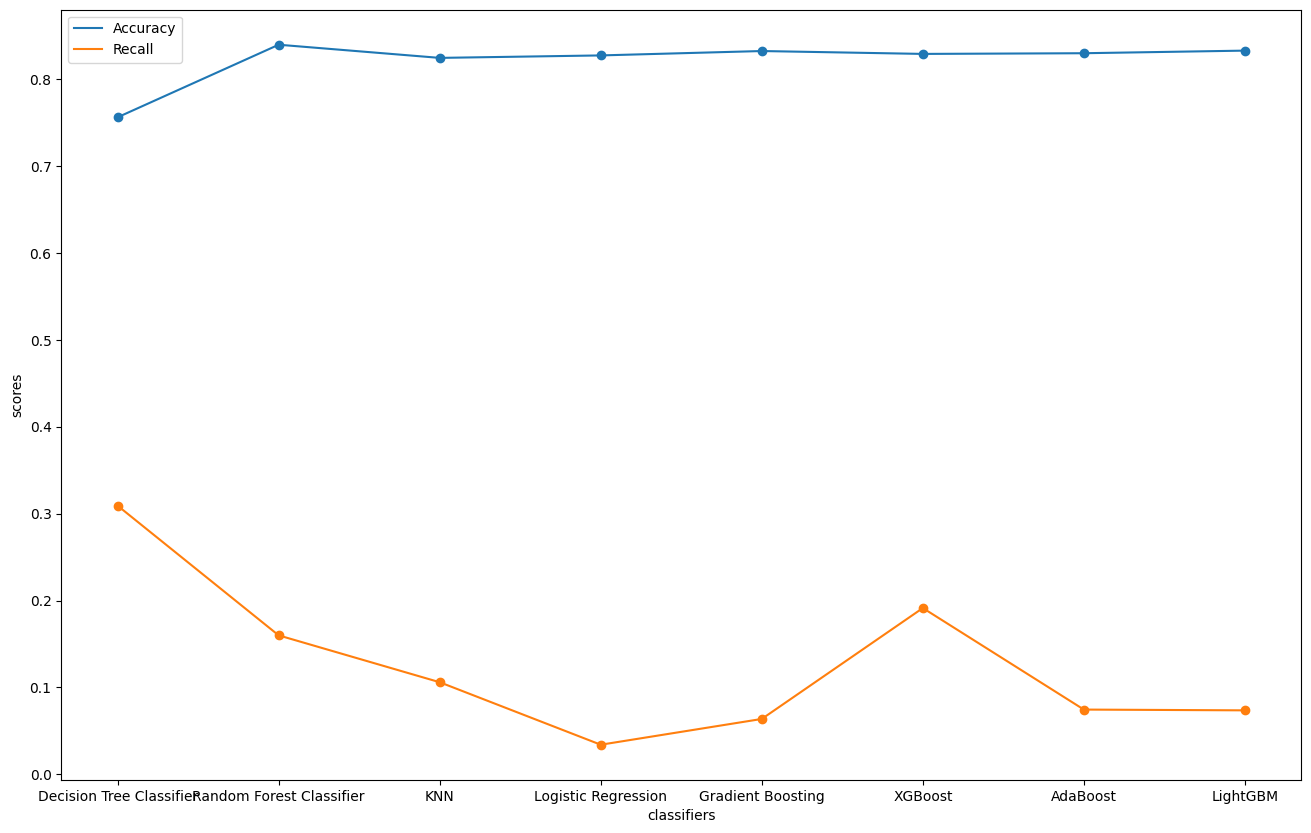

In [ ]:
classifiers(x_train, y_train, x_test, y_test)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.30)

In [ ]:
model = Sequential([
    Conv2D(32, 3, input_shape=(50,50,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 16)          2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 16)         0

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
model.fit(x_train, y_train,batch_size=32,epochs=5,validation_data=(x_test, y_test))

Epoch 1/5
463/463 [==============================] - 22s 13ms/step - loss: 0.4271 - accuracy: 0.8327 - val_loss: 0.4137 - val_accuracy: 0.8362
Epoch 2/5
463/463 [==============================] - 4s 8ms/step - loss: 0.3853 - accuracy: 0.8449 - val_loss: 0.3821 - val_accuracy: 0.8402
Epoch 3/5
463/463 [==============================] - 5s 10ms/step - loss: 0.3669 - accuracy: 0.8487 - val_loss: 0.3834 - val_accuracy: 0.8441
Epoch 4/5
463/463 [==============================] - 3s 7ms/step - loss: 0.3513 - accuracy: 0.8535 - val_loss: 0.3735 - val_accuracy: 0.8446
Epoch 5/5
463/463 [==============================] - 3s 7ms/step - loss: 0.3416 - accuracy: 0.8566 - val_loss: 0.3684 - val_accuracy: 0.8455


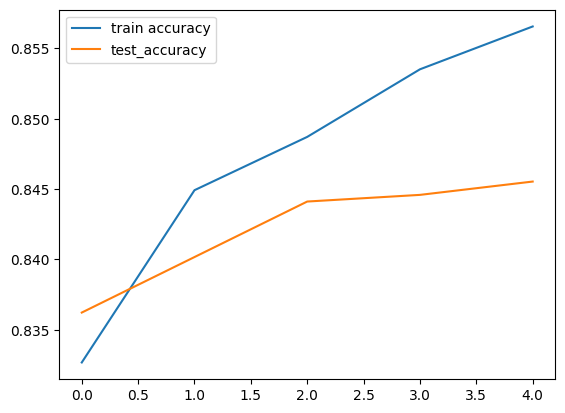

In [ ]:
plt.plot(model.history.history['accuracy'], label = 'train accuracy')
plt.plot(model.history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

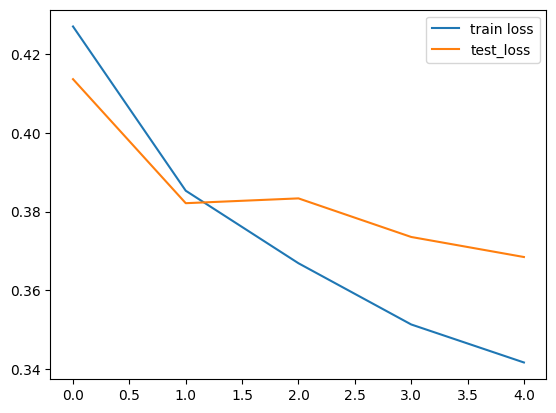

In [ ]:
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

In [ ]:
model.compile(optimizer='SGD', loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
model.fit(x_train, y_train,batch_size=32,epochs=5,validation_data=(x_test, y_test))

Epoch 1/5
463/463 [==============================] - 8s 10ms/step - loss: 0.3086 - accuracy: 0.8696 - val_loss: 0.3812 - val_accuracy: 0.8331
Epoch 2/5
463/463 [==============================] - 5s 10ms/step - loss: 0.3031 - accuracy: 0.8737 - val_loss: 0.3678 - val_accuracy: 0.8441
Epoch 3/5
463/463 [==============================] - 4s 9ms/step - loss: 0.2999 - accuracy: 0.8756 - val_loss: 0.4015 - val_accuracy: 0.8220
Epoch 4/5
463/463 [==============================] - 3s 7ms/step - loss: 0.2968 - accuracy: 0.8764 - val_loss: 0.3730 - val_accuracy: 0.8482
Epoch 5/5
463/463 [==============================] - 3s 7ms/step - loss: 0.2940 - accuracy: 0.8782 - val_loss: 0.3669 - val_accuracy: 0.8493


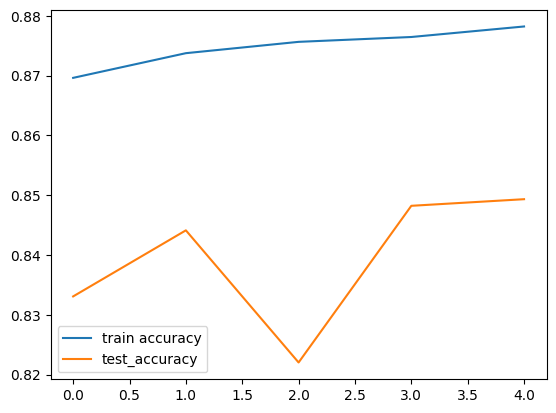

In [ ]:
plt.plot(model.history.history['accuracy'], label = 'train accuracy')
plt.plot(model.history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

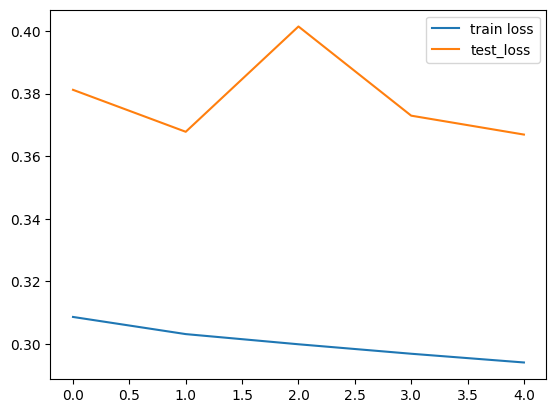

In [ ]:
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

# Filtered images 

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
df.head()
urls = os.listdir('/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images')
path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images/" + urls[0]

In [ ]:
def loadImages(path, urls, target):
  images = []
  labels = []
  for i in range(len(urls)):
    img_path = path + "/" + urls[i]
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gray = img_gray / 255.0
    # if we want to resize the images
    img = cv2.resize(img_gray, (50,50))
    images.append(img)
    labels.append(target)
  images = np.asarray(images)
  return images, labels

In [ ]:
covid_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/COVID/images"
covidUrl = os.listdir(covid_path)
covidImages, covidTargets = loadImages(covid_path, covidUrl, 1)
print(len(covidUrl), "covid images")

normal_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Normal/images"
normal_urls = os.listdir(normal_path)
normalImages, normalTargets = loadImages(normal_path, normal_urls, 0)
print(len(normal_urls),"normal images")

lo_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Lung_Opacity/images"
lo_urls = os.listdir(lo_path)
loImages, loTargets = loadImages(lo_path, lo_urls, 0)
print(len(lo_urls),"Lung Opacity images")

vp_path = "/content/drive/MyDrive/PRML2/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
vp_urls = os.listdir(vp_path)
vpImages, vpTargets = loadImages(vp_path, vp_urls, 0)
print(len(vp_urls),"Viral Pneumonia images")


data = np.r_[covidImages, normalImages,loImages,vpImages]
targets = np.r_[covidTargets, normalTargets, loTargets, vpTargets]

3616 covid images
10164 normal images
6012 Lung Opacity images
1331 Viral Pneumonia images


In [ ]:
# Display the original image and the processed image
def plot_images(title, image1,image2):
    # Plot both images
    plt.figure()
    fig, ax = plt.subplots(1,2,figsize=(5,5))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(image1,cmap='gray')
    plt.subplot(1,2,2)
    plt.title("After Filter")
    plt.imshow(image2,cmap='gray')
    plt.show()

In [ ]:
def apply_filter(f, img):
    if f == 'equalize_hist':
        img = equalize_hist(img, nbins=256, mask=None)
        
    return img

<Figure size 640x480 with 0 Axes>

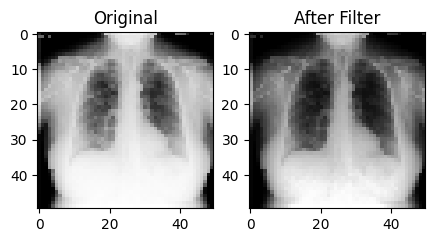

In [ ]:
itr=0
for i in range(len(data)):
  image_out = apply_filter('equalize_hist', data[i])
  if (itr==0):
    plot_images('Histogram Equalization',data[i], image_out)
    itr+=1
  data[i]= image_out

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
data=np.array(data)
np.resize(data,(len(data), 50, 50, 3))
resize_data=np.resize(data,(len(data),7500))
scale= StandardScaler()
scaled_data = scale.fit_transform(resize_data) 
x_train, x_test, y_train, y_test = train_test_split(scaled_data, targets, test_size=0.30)

Classifiers

In [ ]:
def classifiers(x_train, y_train, x_test, y_test):
  clf = DecisionTreeClassifier()
  clf.fit(x_train, y_train)
  score = clf.score(x_test, y_test)
  print("Accuracy of Decision Tree Classifier:", score)
  y_pred = clf.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_clf = recall_score( y_test, y_pred)
  print("Recall Score of Decision Tree Classifier:", recall_clf)
  print(classification_report(y_test, y_pred, target_names=target_names))

  rfc = RandomForestClassifier(n_estimators=20, random_state=42)
  rfc.fit(x_train, y_train)
  score_rfc = rfc.score(x_test, y_test)
  print('Accuracy of Random Forest  Classifier:', score_rfc)
  y_pred = rfc.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_rfc = recall_score(y_test, y_pred)
  print("Recall Score of Random Forest Classifier:", recall_rfc)
  print(classification_report(y_test, y_pred, target_names=target_names))

  knn = KNeighborsClassifier(n_neighbors=4)
  knn.fit(x_train, y_train)
  score_knn = knn.score(x_test, y_test)
  print('Accuracy of K Nearest Neighbours Classifier:', score_knn)
  y_pred = knn.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_knn = recall_score(y_test, y_pred)
  print("Recall Score of K Nearest Neighbours Classifier:", recall_knn)
  print(classification_report(y_test, y_pred, target_names=target_names))

  logreg = LogisticRegression(random_state=42)
  logreg.fit(x_train, y_train)
  score_logreg = logreg.score(x_test, y_test)
  print('Accuracy of Logistic Regression:', score_logreg)
  y_pred = logreg.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_logreg = recall_score(y_test, y_pred)
  print("Recall Score of Logistic Regression:", recall_logreg)  
  print(classification_report(y_test, y_pred, target_names=target_names))

  gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
  gbc.fit(x_train, y_train)
  score_gbc = gbc.score(x_test, y_test)
  print('Accuracy of Gradient Boosting:', score_gbc)
  y_pred = gbc.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_gbc = recall_score(y_test, y_pred)
  print("Recall Score of Gradient Boosting:", recall_gbc)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_xgboost=xgboost.XGBClassifier(subsample=0.7)
  classifier_xgboost.fit(x_train, y_train)
  score_xgboost = classifier_xgboost.score(x_test, y_test)
  print('Accuracy of XGBoost:', score_xgboost)
  y_pred = classifier_xgboost.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_xgboost = recall_score(y_test, y_pred)
  print("Recall Score of XGBoost:", recall_classifier_xgboost)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_AdaBoost=AdaBoostClassifier()
  classifier_AdaBoost.fit(x_train, y_train)
  score_AdaBoost = classifier_AdaBoost.score(x_test, y_test)
  print('Accuracy of AdaBoost Classifier:', score_AdaBoost)
  y_pred = classifier_AdaBoost.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_AdaBoost = recall_score(y_test, y_pred)
  print("Recall Score of AdaBoost Classifier:", recall_classifier_AdaBoost)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_lightgbm=lightgbm.LGBMClassifier(num_leaves=6)
  classifier_lightgbm.fit(x_train, y_train)
  score_lightgbm = classifier_lightgbm.score(x_test, y_test)
  print('Accuracy of LightGBM Classifier:', score_lightgbm)
  y_pred = classifier_lightgbm.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_lightgbm = recall_score(y_test, y_pred)
  print("Recall Score of LightGBM Classifier:", recall_classifier_lightgbm)
  print(classification_report(y_test, y_pred, target_names=target_names))
  

  plt.figure(figsize=(16,10))
  classifiers = ['Decision Tree Classifier', 'Random Forest Classifier', 'KNN', 'Logistic Regression', 'Gradient Boosting', 'XGBoost', 'AdaBoost','LightGBM']
  accuracies = [score, score_rfc, score_knn, score_logreg, score_gbc, score_xgboost, score_AdaBoost, score_lightgbm]
  recall = [recall_clf, recall_rfc, recall_knn, recall_logreg, recall_gbc, recall_classifier_xgboost, recall_classifier_AdaBoost, recall_classifier_lightgbm]
  plt.plot(classifiers, accuracies , label = 'Accuracy')
  plt.scatter(classifiers, accuracies )

  plt.plot(classifiers, recall , label = 'Recall')
  plt.scatter(classifiers, recall )

  plt.xlabel('classifiers')
  plt.ylabel('scores')
  plt.legend()
  plt.show()

Accuracy of Decision Tree Classifier: 0.7596654568407764
Recall Score of Decision Tree Classifier: 0.0037002775208140612
              precision    recall  f1-score   support

     Class 0       0.82      0.92      0.86      5256
     Class 1       0.01      0.00      0.01      1081

    accuracy                           0.76      6337
   macro avg       0.41      0.46      0.43      6337
weighted avg       0.68      0.76      0.72      6337

Accuracy of Random Forest  Classifier: 0.7053810951554363
Recall Score of Random Forest Classifier: 0.0
              precision    recall  f1-score   support

     Class 0       0.81      0.85      0.83      5256
     Class 1       0.00      0.00      0.00      1081

    accuracy                           0.71      6337
   macro avg       0.40      0.43      0.41      6337
weighted avg       0.67      0.71      0.69      6337

Accuracy of K Nearest Neighbours Classifier: 0.8245226447845984
Recall Score of K Nearest Neighbours Classifier: 0.000925

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of Logistic Regression: 0.706959128925359
Recall Score of Logistic Regression: 0.020351526364477335
              precision    recall  f1-score   support

     Class 0       0.81      0.85      0.83      5256
     Class 1       0.03      0.02      0.02      1081

    accuracy                           0.71      6337
   macro avg       0.42      0.43      0.43      6337
weighted avg       0.67      0.71      0.69      6337

Accuracy of Gradient Boosting: 0.8267318920624901
Recall Score of Gradient Boosting: 0.0
              precision    recall  f1-score   support

     Class 0       0.83      1.00      0.91      5256
     Class 1       0.00      0.00      0.00      1081

    accuracy                           0.83      6337
   macro avg       0.41      0.50      0.45      6337
weighted avg       0.69      0.83      0.75      6337

Accuracy of XGBoost: 0.695755089158908
Recall Score of XGBoost: 0.005550416281221091
              precision    recall  f1-score   support

     Cla

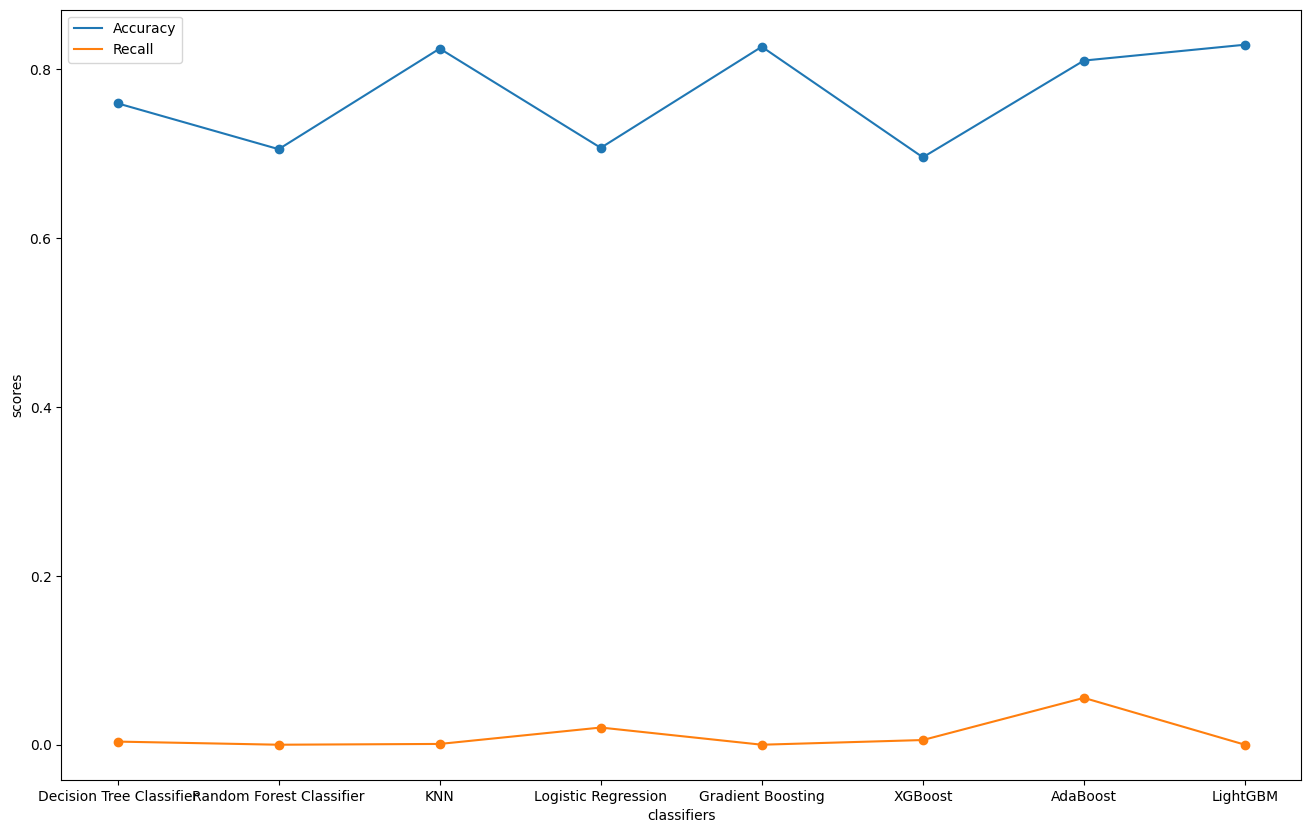

In [ ]:
classifiers(x_train, y_train, x_test, y_test)

# CNN on Filtered images

In [ ]:
data=np.resize(data,(len(data),50,50,3))
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.30)

In [ ]:
model = Sequential([
    Conv2D(32, 3, input_shape=(50,50,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 16)          2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 16)         0

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
model.fit(x_train, y_train,batch_size=32,epochs=5,validation_data=(x_test, y_test))

Epoch 1/5
463/463 [==============================] - 17s 10ms/step - loss: 0.4398 - accuracy: 0.8279 - val_loss: 0.4113 - val_accuracy: 0.8310
Epoch 2/5
463/463 [==============================] - 3s 6ms/step - loss: 0.4188 - accuracy: 0.8279 - val_loss: 0.4465 - val_accuracy: 0.8310
Epoch 3/5
463/463 [==============================] - 3s 6ms/step - loss: 0.4133 - accuracy: 0.8279 - val_loss: 0.4112 - val_accuracy: 0.8310
Epoch 4/5
463/463 [==============================] - 3s 6ms/step - loss: 0.4068 - accuracy: 0.8279 - val_loss: 0.4019 - val_accuracy: 0.8310
Epoch 5/5
463/463 [==============================] - 4s 8ms/step - loss: 0.4067 - accuracy: 0.8279 - val_loss: 0.3995 - val_accuracy: 0.8310


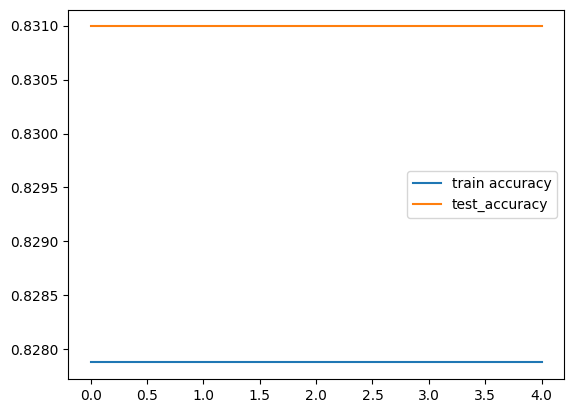

In [ ]:
plt.plot(model.history.history['accuracy'], label = 'train accuracy')
plt.plot(model.history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

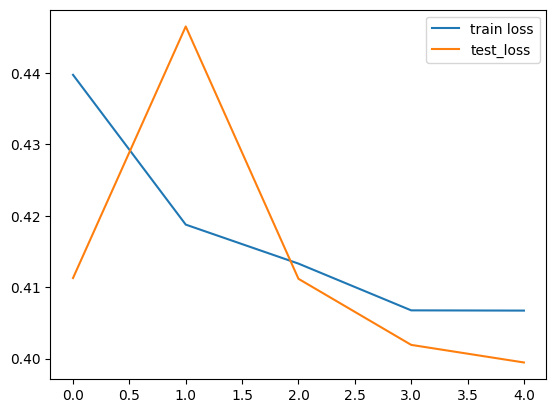

In [ ]:
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

In [ ]:
model.compile(optimizer='SGD', loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
model.fit(x_train, y_train,batch_size=32,epochs=5,validation_data=(x_test, y_test))

Epoch 1/5
463/463 [==============================] - 5s 7ms/step - loss: 0.3967 - accuracy: 0.8279 - val_loss: 0.3989 - val_accuracy: 0.8310
Epoch 2/5
463/463 [==============================] - 3s 6ms/step - loss: 0.3951 - accuracy: 0.8279 - val_loss: 0.3977 - val_accuracy: 0.8310
Epoch 3/5
463/463 [==============================] - 4s 9ms/step - loss: 0.3942 - accuracy: 0.8279 - val_loss: 0.3958 - val_accuracy: 0.8310
Epoch 4/5
463/463 [==============================] - 3s 6ms/step - loss: 0.3930 - accuracy: 0.8279 - val_loss: 0.4027 - val_accuracy: 0.8310
Epoch 5/5
463/463 [==============================] - 3s 6ms/step - loss: 0.3931 - accuracy: 0.8279 - val_loss: 0.3971 - val_accuracy: 0.8310


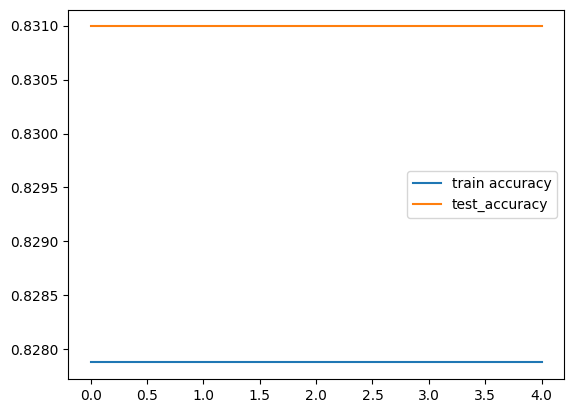

In [ ]:
plt.plot(model.history.history['accuracy'], label = 'train accuracy')
plt.plot(model.history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

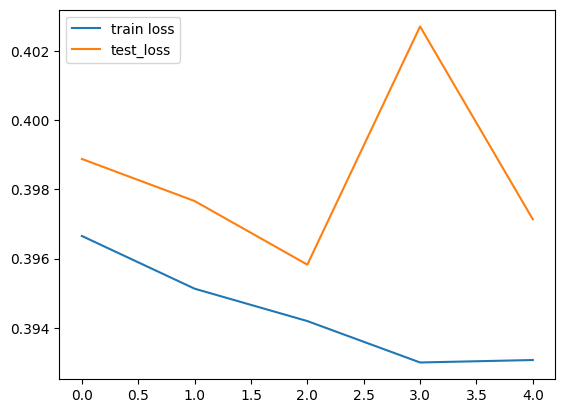

In [ ]:
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

#UNet

In [ ]:
urls_img = os.listdir('/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/COVID/images')
path_img = "/content/drive/MyDrive/PRML lab data /Major Project/COVID-19_Radiography_Dataset/COVID/images/" + urls_img[0]
path_img

'/content/drive/MyDrive/PRML lab data /Major Project/COVID-19_Radiography_Dataset/COVID/images/COVID-3237.png'

In [ ]:
urls_mask = os.listdir('/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/COVID/masks')
path_mask = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/COVID/masks/" + urls_mask[0]
path_mask

'/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/COVID/masks/COVID-618.png'

In [ ]:
def loadImages(path, urls):
  images = []
  for i in range(len(urls)):
    img = path + "/" + urls[i]
    img = cv2.imread(img)
    img = img / 255.0
    #print(img_path)
    # if we want to resize the images
    img = cv2.resize(img, (48,48))
    images.append(img)
  images = np.asarray(images)
  return images

In [ ]:
covid_path_img = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/COVID/images"
covidUrl_img = os.listdir(covid_path_img)

covidImages = loadImages(covid_path_img, covidUrl_img)
len(covidUrl_img), len(covidImages)

(3616, 3616)

In [ ]:
covid_path_mask = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/COVID/masks"
covidUrl_mask = os.listdir(covid_path_mask)
covidTargets = loadImages(covid_path_mask, covidUrl_mask)

In [ ]:
covidTargets.shape

(3616, 48, 48, 3)

In [ ]:
normal_path_img = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Normal/images"
normal_urls_img = os.listdir(normal_path_img)
normalImages = loadImages(normal_path_img, normal_urls_img)

In [ ]:
normalImages.shape

(10192, 48, 48, 3)

In [ ]:
normal_path_mask = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Normal/masks"
normal_urls_mask = os.listdir(normal_path_mask)
normalTargets = loadImages(normal_path_mask , normal_urls_mask)

normalTargets.shape

(10192, 48, 48, 3)

In [ ]:
lo_path_img = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Lung_Opacity/images"
lo_urls_img = os.listdir(lo_path_img)
loImages = loadImages(lo_path_img, lo_urls_img)

In [ ]:
loImages.shape

(6012, 48, 48, 3)

In [ ]:
lo_path_mask = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Lung_Opacity/masks"
lo_urls_mask = os.listdir(lo_path_mask)
loTargets = loadImages(lo_path_mask, lo_urls_mask)

In [ ]:
loTargets.shape

(6012, 48, 48, 3)

In [ ]:
vp_path_img = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Viral Pneumonia/images"
vp_urls_img = os.listdir(vp_path_img)
vpImages = loadImages(vp_path_img, vp_urls_img)

In [ ]:
vpImages.shape

(1345, 48, 48, 3)

In [ ]:
vp_path_mask = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Viral Pneumonia/masks"
vp_urls_mask = os.listdir(vp_path_mask)
vpTargets = loadImages(vp_path_mask, vp_urls_mask)

In [ ]:
vpTargets.shape

(1345, 48, 48, 3)

In [ ]:
import pandas as pd

In [ ]:
data = np.r_[covidImages, normalImages,loImages,vpImages]
targets = np.r_[covidTargets, normalTargets, loTargets, vpTargets]

In [ ]:
data.shape

(21165, 48, 48, 3)

## U-Net implementation

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(data,targets,test_size = 0.3 , random_state = 42)

In [ ]:
Img_width = 48
Img_height = 48
Img_channels = 3

In [ ]:
#bulit the model
inputs = Input((Img_width,Img_height,Img_channels))

### Contraction Path

In [ ]:
# convolution layer 1.1
s = Lambda(lambda x: x/255)(inputs)
c1 = Conv2D(8,(3,3),activation = 'relu' , kernel_initializer= 'he_normal', padding= 'same')(inputs)
c1 = Dropout(0.1)(c1)
# colvolution layer 1.2
c1 = Conv2D(8,(3,3),activation = 'relu' , kernel_initializer= 'he_normal', padding= 'same')(c1)
# Maxpooling layer 1
p1 = MaxPooling2D((2,2))(c1)

In [ ]:
# colvolution layer 2.1
c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.2)(c2)  # Original 0.1
# colvolution layer 2.2
c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
# Maxpooling layer 2
p2 = MaxPooling2D((2, 2))(c2)

In [ ]:
# colvolution layer 4.1
c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c4 = Dropout(0.2)(c4)
# convolution layer 4.2
c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

### Expansion Path

In [ ]:
# Up-convolution layer 5 and concatnation
u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = concatenate([u5, c2])
# convolution layer 5.1
c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
c5 = Dropout(0.2)(c5)
# colvolution layer 5.2
c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [ ]:
# Up-convolution layer 6 and concatenation
u6 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c1])
# colnolution layer 6.1
c6 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
# colvolution layer 6.2
c6 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

In [ ]:
# outputs 
outputs = Conv2D(3,(1,1),activation = 'sigmoid')(c6)

In [ ]:
model = Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 8)    224         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 48, 48, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 8)    584         ['dropout[0][0]']                
                                                                                              

In [ ]:
targets.shape

(21165, 48, 48, 3)

In [ ]:
results = model.fit(X_train , y_train , validation_split = 0.1 , batch_size = 32 , epochs = 50 )

Epoch 1/50
417/417 [==============================] - 23s 15ms/step - loss: 0.3811 - accuracy: 0.4463 - val_loss: 0.3003 - val_accuracy: 0.6785
Epoch 2/50
417/417 [==============================] - 4s 10ms/step - loss: 0.3043 - accuracy: 0.4128 - val_loss: 0.2923 - val_accuracy: 0.4253
Epoch 3/50
417/417 [==============================] - 4s 11ms/step - loss: 0.2957 - accuracy: 0.3869 - val_loss: 0.2876 - val_accuracy: 0.3416
Epoch 4/50
417/417 [==============================] - 5s 12ms/step - loss: 0.2925 - accuracy: 0.3722 - val_loss: 0.2849 - val_accuracy: 0.4024
Epoch 5/50
417/417 [==============================] - 4s 10ms/step - loss: 0.2912 - accuracy: 0.3648 - val_loss: 0.2856 - val_accuracy: 0.4557
Epoch 6/50
417/417 [==============================] - 4s 10ms/step - loss: 0.2899 - accuracy: 0.3588 - val_loss: 0.2851 - val_accuracy: 0.3774
Epoch 7/50
417/417 [==============================] - 5s 12ms/step - loss: 0.2894 - accuracy: 0.3556 - val_loss: 0.2878 - val_accuracy: 0.233

In [ ]:
Predictions = model.predict(data)

660/660 [==============================] - 30s 43ms/step


In [ ]:
Predictions = np.asarray(Predictions)
predictions=np.resize(Predictions,(len(Predictions),48*48*3))

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(predictions,cls , test_size = 0.3)

In [ ]:

def classifiers(x_train, y_train, x_test, y_test):
  clf = DecisionTreeClassifier()
  clf.fit(x_train, y_train)
  score = clf.score(x_test, y_test)
  print("Accuracy of Decision Tree Classifier:", score)
  y_pred = clf.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_clf = recall_score( y_test, y_pred)
  print("Recall Score of Decision Tree Classifier:", recall_clf)
  print(classification_report(y_test, y_pred, target_names=target_names))

  rfc = RandomForestClassifier(n_estimators=20, random_state=42)
  rfc.fit(x_train, y_train)
  score_rfc = rfc.score(x_test, y_test)
  print('Accuracy of Random Forest  Classifier:', score_rfc)
  y_pred = rfc.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_rfc = recall_score(y_test, y_pred)
  print("Recall Score of Random Forest Classifier:", recall_rfc)
  print(classification_report(y_test, y_pred, target_names=target_names))

  logreg = LogisticRegression(random_state=42)
  logreg.fit(x_train, y_train)
  score_logreg = logreg.score(x_test, y_test)
  print('Accuracy of Logistic Regression:', score_logreg)
  y_pred = logreg.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_logreg = recall_score(y_test, y_pred)
  print("Recall Score of Logistic Regression:", recall_logreg)  
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_xgboost=xgboost.XGBClassifier(subsample=0.7)
  classifier_xgboost.fit(x_train, y_train)
  score_xgboost = classifier_xgboost.score(x_test, y_test)
  print('Accuracy of XGBoost:', score_xgboost)
  y_pred = classifier_xgboost.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_xgboost = recall_score(y_test, y_pred)
  print("Recall Score of XGBoost:", recall_classifier_xgboost)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_AdaBoost=AdaBoostClassifier()
  classifier_AdaBoost.fit(x_train, y_train)
  score_AdaBoost = classifier_AdaBoost.score(x_test, y_test)
  print('Accuracy of AdaBoost Classifier:', score_AdaBoost)
  y_pred = classifier_AdaBoost.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_AdaBoost = recall_score(y_test, y_pred)
  print("Recall Score of AdaBoost Classifier:", recall_classifier_AdaBoost)
  print(classification_report(y_test, y_pred, target_names=target_names))

  classifier_lightgbm=lightgbm.LGBMClassifier(num_leaves=6)
  classifier_lightgbm.fit(x_train, y_train)
  score_lightgbm = classifier_lightgbm.score(x_test, y_test)
  print('Accuracy of LightGBM Classifier:', score_lightgbm)
  y_pred = classifier_lightgbm.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_classifier_lightgbm = recall_score(y_test, y_pred)
  print("Recall Score of LightGBM Classifier:", recall_classifier_lightgbm)
  print(classification_report(y_test, y_pred, target_names=target_names))
  
  gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
  gbc.fit(x_train, y_train)
  score_gbc = gbc.score(x_test, y_test)
  print('Accuracy of Gradient Boosting:', score_gbc)
  y_pred = gbc.predict(x_test)
  target_names = ["Class 0", "Class 1"]
  recall_gbc = recall_score(y_test, y_pred)
  print("Recall Score of Gradient Boosting:", recall_gbc)
  print(classification_report(y_test, y_pred, target_names=target_names))

  plt.figure(figsize=(16,10))
  classifiers = ['Decision Tree Classifier', 'Random Forest Classifier', 'KNN', 'Logistic Regression', 'Gradient Boosting', 'XGBoost', 'AdaBoost','LightGBM']
  accuracies = [score, score_rfc, score_knn, score_logreg, score_gbc, score_xgboost, score_AdaBoost, score_lightgbm]
  recall = [recall_clf, recall_rfc, recall_knn, recall_logreg, recall_gbc, recall_classifier_xgboost, recall_classifier_AdaBoost, recall_classifier_lightgbm]
  plt.plot(classifiers, accuracies , label = 'Accuracy')
  plt.scatter(classifiers, accuracies )

  plt.plot(classifiers, recall , label = 'Recall')
  plt.scatter(classifiers, recall )

  plt.xlabel('classifiers')
  plt.ylabel('scores')
  plt.legend()
  plt.show()

Accuracy of Decision Tree Classifier: 0.8658247829518547
Recall Score of Decision Tree Classifier: 0.5998168498168498
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92      5243
     Class 1       0.61      0.60      0.61      1092

    accuracy                           0.87      6335
   macro avg       0.77      0.76      0.76      6335
weighted avg       0.86      0.87      0.87      6335

Accuracy of Random Forest  Classifier: 0.9131807419100236
Recall Score of Random Forest Classifier: 0.5476190476190477
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95      5243
     Class 1       0.91      0.55      0.68      1092

    accuracy                           0.91      6335
   macro avg       0.91      0.77      0.82      6335
weighted avg       0.91      0.91      0.90      6335



C:\Users\91727\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of Logistic Regression: 0.8648776637726914
Recall Score of Logistic Regression: 0.3443223443223443
              precision    recall  f1-score   support

     Class 0       0.88      0.97      0.92      5243
     Class 1       0.73      0.34      0.47      1092

    accuracy                           0.86      6335
   macro avg       0.80      0.66      0.70      6335
weighted avg       0.85      0.86      0.84      6335

Accuracy of XGBoost: 0.9423835832675612
Recall Score of XGBoost: 0.7298534798534798
              precision    recall  f1-score   support

     Class 0       0.95      0.99      0.97      5243
     Class 1       0.92      0.73      0.81      1092

    accuracy                           0.94      6335
   macro avg       0.93      0.86      0.89      6335
weighted avg       0.94      0.94      0.94      6335

Accuracy of AdaBoost Classifier: 0.8828729281767956
Recall Score of AdaBoost Classifier: 0.5265567765567766
              precision    recall  f1-score   

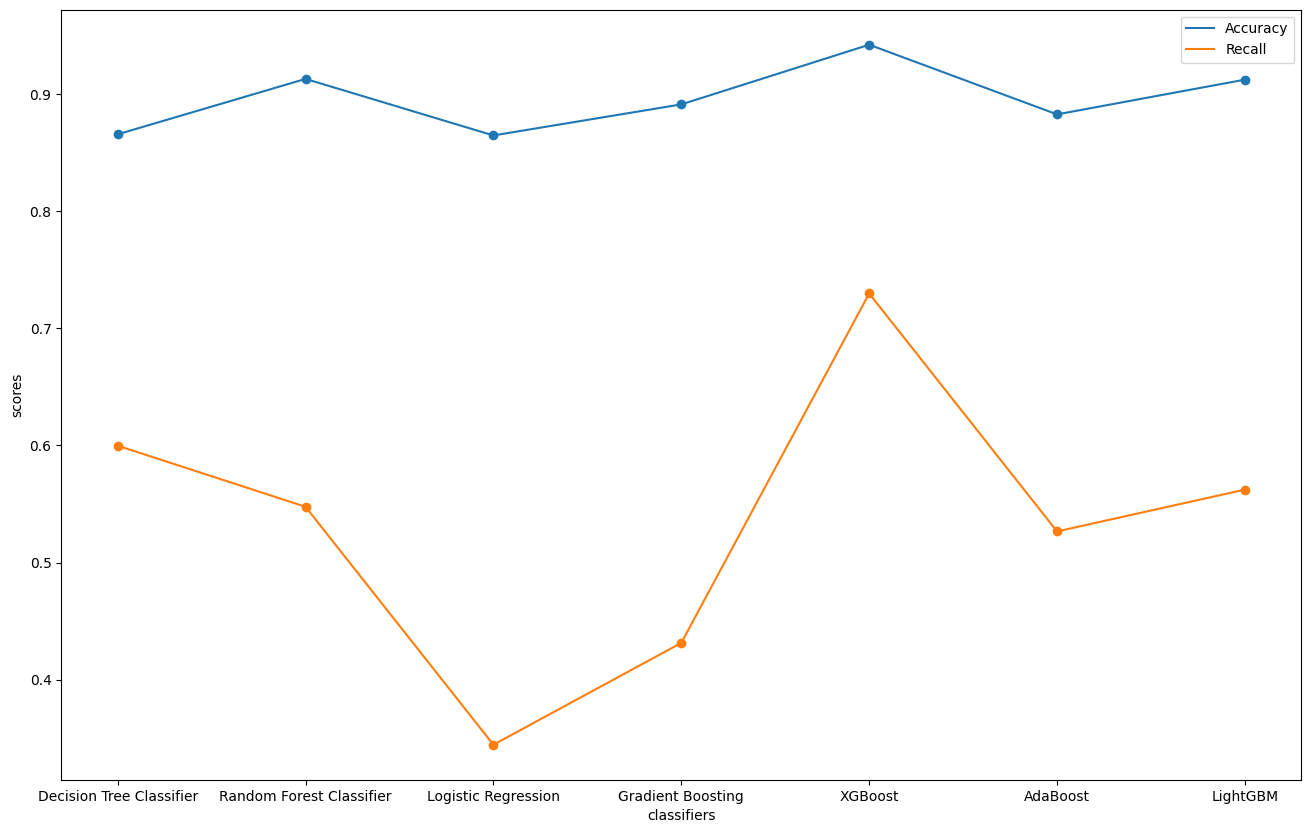

In [ ]:
classifiers(x_train,y_train,x_test,y_test)

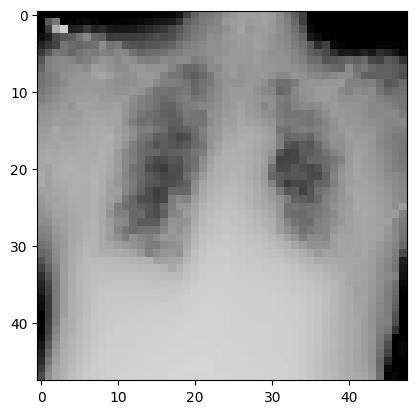

In [ ]:
plt.imshow(data1[0],cmap='gray')

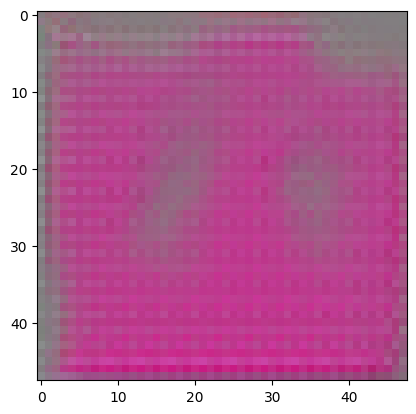

In [ ]:
plt.imshow(Predictions[0],cmap='gray')

#ANN

In [ ]:
def loadImages(path, urls, target):
  images = []
  labels = []
  for i in range(len(urls)):
    img = path + "/" + urls[i]
    img = cv2.imread(img)
    img = img / 255.0
    img = cv2.resize(img, (48,48))
    images.append(img)
    labels.append(target)
  labels =  np.asarray(labels)
  images = np.asarray(images)
  return images , labels

In [ ]:
covid_path_img = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/COVID/images"
covidUrl_img = os.listdir(covid_path_img)

covidImages , covidTargets = loadImages(covid_path_img, covidUrl_img,1)

In [ ]:
covid_path_mask = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/COVID/masks"
covidUrl_mask = os.listdir(covid_path_mask)

covidMasks , covidTargets = loadImages(covid_path_mask, covidUrl_mask,1)

In [ ]:
normal_path_img = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Normal/images"
normalUrl_img = os.listdir(normal_path_img)

normalImages , normalTargets = loadImages(normal_path_img, normalUrl_img,0)

In [ ]:
normal_path_mask = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Normal/masks"
normalUrl_mask = os.listdir(normal_path_mask)

normalMasks , normalTargets = loadImages(normal_path_mask, normalUrl_mask,0)

In [ ]:
lo_path_img = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Lung_Opacity/images"
loUrl_img = os.listdir(lo_path_img)

loImages , loTargets = loadImages(lo_path_img, loUrl_img,0)

In [ ]:
lo_path_mask = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Lung_Opacity/masks"
loUrl_mask = os.listdir(lo_path_mask)

loMasks , loTargets = loadImages(lo_path_mask, loUrl_mask,0)

In [ ]:
vp_path_img = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Viral Pneumonia/images"
vpUrl_img = os.listdir(vp_path_img)

vpImages , vpTargets = loadImages(vp_path_img, vpUrl_img,0)

In [ ]:
vp_path_mask = "/content/drive/MyDrive/Major Project /COVID-19_Radiography_Dataset/Viral Pneumonia/masks"
vpUrl_mask = os.listdir(vp_path_mask)

vpMasks , vpTargets = loadImages(vp_path_mask, vpUrl_mask,0)

In [ ]:
import pandas as pd

In [ ]:
data = np.r_[covidImages, normalImages,loImages,vpImages]
data_mask = np.r_[covidMasks, normalMasks,loMasks,vpMasks]
targets = np.r_[covidTargets, normalTargets, loTargets, vpTargets]

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(data,targets,test_size = 0.3 , random_state = 42)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential(
    [
        layers.Flatten(),
        layers.Dense(512, activation="relu", input_shape=(48*48*3,)),
        layers.Dense(512, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.01),
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/10
463/463 [==============================] - 16s 33ms/step - loss: 0.4836 - accuracy: 0.8194 - val_loss: 0.3897 - val_accuracy: 0.8403
Epoch 2/10
463/463 [==============================] - 15s 32ms/step - loss: 0.3984 - accuracy: 0.8296 - val_loss: 0.3665 - val_accuracy: 0.8299
Epoch 3/10
463/463 [==============================] - 24s 52ms/step - loss: 0.3803 - accuracy: 0.8283 - val_loss: 0.3714 - val_accuracy: 0.8301
Epoch 4/10
463/463 [==============================] - 17s 36ms/step - loss: 0.3679 - accuracy: 0.8350 - val_loss: 0.3606 - val_accuracy: 0.8454
Epoch 5/10
463/463 [==============================] - 17s 36ms/step - loss: 0.3579 - accuracy: 0.8437 - val_loss: 0.3508 - val_accuracy: 0.8520
Epoch 6/10
463/463 [==============================] - 16s 34ms/step - loss: 0.3563 - accuracy: 0.8412 - val_loss: 0.3504 - val_accuracy: 0.8513
Epoch 7/10
463/463 [==============================] - 18s 38ms/step - loss: 0.3493 - accuracy: 0.8453 - val_loss: 0.3606 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

199/199 - 1s - loss: 0.3444 - accuracy: 0.8504 - 1s/epoch - 7ms/step
Test accuracy: 0.8503937125205994


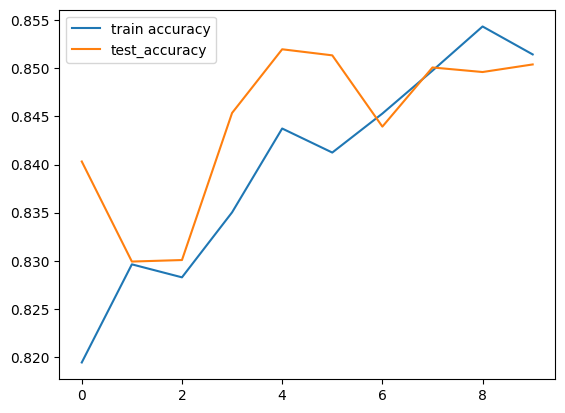

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

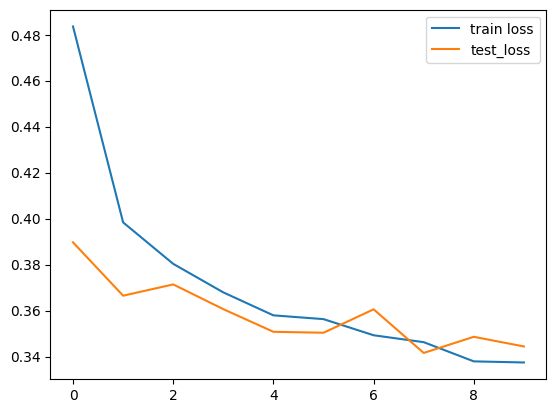

In [ ]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(data_mask,targets,test_size = 0.3 , random_state = 42)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/10
463/463 [==============================] - 17s 36ms/step - loss: 0.4317 - accuracy: 0.8327 - val_loss: 0.3948 - val_accuracy: 0.8422
Epoch 2/10
463/463 [==============================] - 16s 36ms/step - loss: 0.3990 - accuracy: 0.8398 - val_loss: 0.3911 - val_accuracy: 0.8439
Epoch 3/10
463/463 [==============================] - 15s 33ms/step - loss: 0.3857 - accuracy: 0.8437 - val_loss: 0.3879 - val_accuracy: 0.8446
Epoch 4/10
463/463 [==============================] - 15s 33ms/step - loss: 0.3774 - accuracy: 0.8445 - val_loss: 0.3777 - val_accuracy: 0.8455
Epoch 5/10
463/463 [==============================] - 18s 40ms/step - loss: 0.3704 - accuracy: 0.8464 - val_loss: 0.3806 - val_accuracy: 0.8446
Epoch 6/10
463/463 [==============================] - 16s 34ms/step - loss: 0.3615 - accuracy: 0.8501 - val_loss: 0.3849 - val_accuracy: 0.8476
Epoch 7/10
463/463 [==============================] - 16s 36ms/step - loss: 0.3578 - accuracy: 0.8530 - val_loss: 0.3895 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

199/199 - 2s - loss: 0.4206 - accuracy: 0.8339 - 2s/epoch - 9ms/step
Test accuracy: 0.8338582515716553


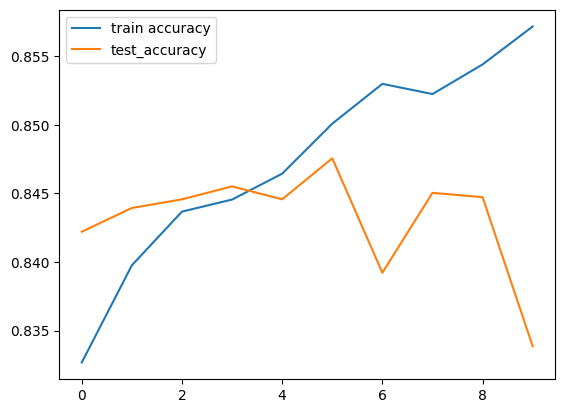

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

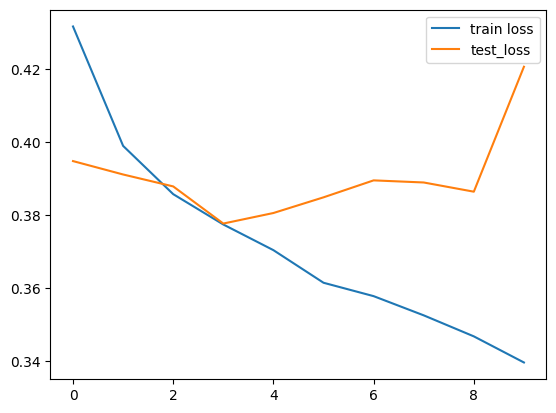

In [ ]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/10
463/463 [==============================] - 9s 18ms/step - loss: 0.3216 - accuracy: 0.8614 - val_loss: 0.3890 - val_accuracy: 0.8457
Epoch 2/10
463/463 [==============================] - 9s 19ms/step - loss: 0.3182 - accuracy: 0.8640 - val_loss: 0.3891 - val_accuracy: 0.8436
Epoch 3/10
463/463 [==============================] - 9s 19ms/step - loss: 0.3155 - accuracy: 0.8641 - val_loss: 0.3907 - val_accuracy: 0.8430
Epoch 4/10
463/463 [==============================] - 8s 17ms/step - loss: 0.3153 - accuracy: 0.8647 - val_loss: 0.3969 - val_accuracy: 0.8471
Epoch 5/10
463/463 [==============================] - 9s 19ms/step - loss: 0.3140 - accuracy: 0.8645 - val_loss: 0.3950 - val_accuracy: 0.8472
Epoch 6/10
463/463 [==============================] - 10s 21ms/step - loss: 0.3134 - accuracy: 0.8666 - val_loss: 0.3960 - val_accuracy: 0.8427
Epoch 7/10
463/463 [==============================] - 8s 17ms/step - loss: 0.3131 - accuracy: 0.8649 - val_loss: 0.3955 - val_accuracy: 0.846

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

199/199 - 1s - loss: 0.3989 - accuracy: 0.8455 - 1s/epoch - 6ms/step
Test accuracy: 0.845511794090271


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

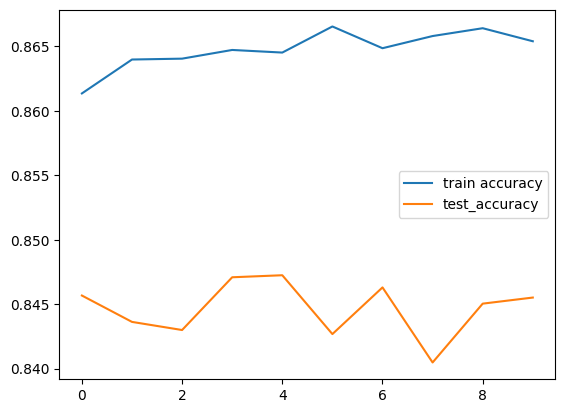

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

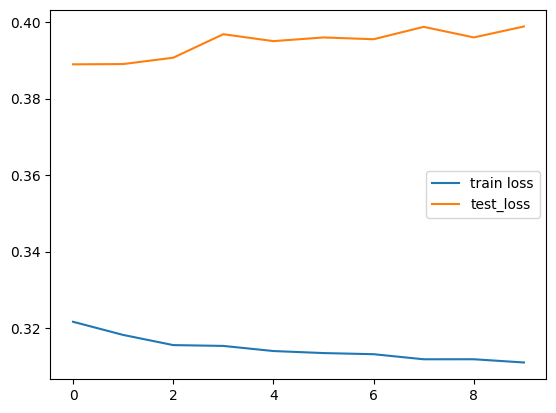

In [ ]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(data_mask,targets,test_size = 0.3 , random_state = 42)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/10
463/463 [==============================] - 9s 19ms/step - loss: 0.3102 - accuracy: 0.8663 - val_loss: 0.3975 - val_accuracy: 0.8457
Epoch 2/10
463/463 [==============================] - 9s 19ms/step - loss: 0.3097 - accuracy: 0.8668 - val_loss: 0.3990 - val_accuracy: 0.8413
Epoch 3/10
463/463 [==============================] - 8s 17ms/step - loss: 0.3095 - accuracy: 0.8666 - val_loss: 0.4001 - val_accuracy: 0.8431
Epoch 4/10
463/463 [==============================] - 9s 19ms/step - loss: 0.3090 - accuracy: 0.8672 - val_loss: 0.4012 - val_accuracy: 0.8411
Epoch 5/10
463/463 [==============================] - 9s 19ms/step - loss: 0.3087 - accuracy: 0.8659 - val_loss: 0.4007 - val_accuracy: 0.8461
Epoch 6/10
463/463 [==============================] - 8s 18ms/step - loss: 0.3077 - accuracy: 0.8680 - val_loss: 0.4053 - val_accuracy: 0.8480
Epoch 7/10
463/463 [==============================] - 9s 19ms/step - loss: 0.3073 - accuracy: 0.8668 - val_loss: 0.4029 - val_accuracy: 0.8461

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

199/199 - 1s - loss: 0.4065 - accuracy: 0.8457 - 1s/epoch - 6ms/step
Test accuracy: 0.8456692695617676


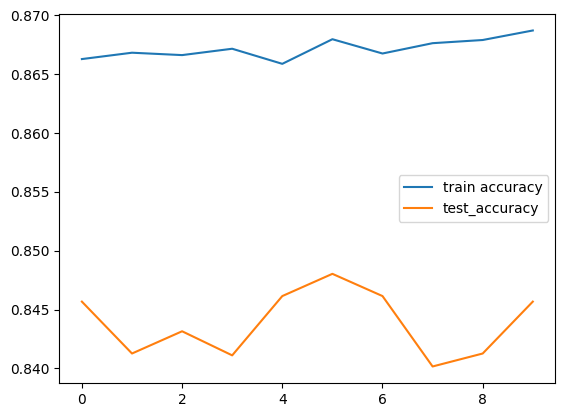

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

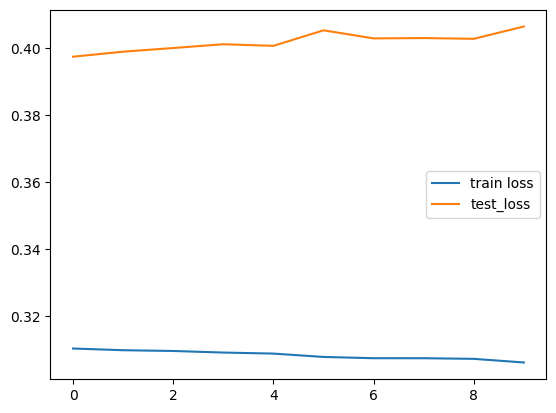

In [ ]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()